In [81]:
import nltk
import pandas as pd
import csv
import keras
from keras.utils import np_utils
from keras.layers import Dense, LSTM, Input, Embedding, Dropout,TimeDistributed ,InputLayer,Activation, Bidirectional,GRU
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import LambdaCallback
import numpy as np
import gensim

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /home/sangil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sangil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# 1. tagg list for POS TAGGING
#    Also Target list
str0 = 'CC coordinating conjunction\n\
CD cardinal digit\n\
DT determiner\n\
EX existential there (like: “there is” … think of it like “there exists”)\n\
FW foreign word\n\
IN preposition/subordinating conjunction\n\
JJ adjective ‘big’\n\
JJR adjective, comparative ‘bigger’\n\
JJS adjective, superlative ‘biggest’\n\
LS list marker 1)\n\
MD modal could, will\n\
NN noun, singular ‘desk’\n\
NNS noun plural ‘desks’\n\
NNP proper noun, singular ‘Harrison’\n\
NNPS proper noun, plural ‘Americans’\n\
PDT predeterminer ‘all the kids’\n\
POS possessive ending parent’s\n\
PRP personal pronoun I, he, she\n\
PRP$ possessive pronoun my, his, hers\n\
RB adverb very, silently,\n\
RBR adverb, comparative better\n\
RBS adverb, superlative best\n\
RP particle give up\n\
TO to go ‘to’ the store.\n\
UH interjection, errrrrrrrm\n\
VB verb, base form take\n\
VBD verb, past tense, took\n\
VBG verb, gerund/present participle taking\n\
VBN verb, past participle is taken\n\
VBP verb, sing. present, known-3d take\n\
VBZ verb, 3rd person sing. present takes\n\
WDT wh-determiner which\n\
WP wh-pronoun who, what\n\
WP$ possessive wh-pronoun whose\n\
WRB wh-adverb where, when\n\
,\n\
\'\n\
.\n\
``\n\
\'\'\n\
(\n\
)\n\
:\n\
$\n\
#\n\
SYM'
l = str0.split('\n')
dic = dict()
for idx,sr in enumerate(l):
    print(sr)
    s = sr.split(' ')[0]
    dic[s] = idx
target_counter = len(dic)

CC coordinating conjunction
CD cardinal digit
DT determiner
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent’s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO to go ‘to’ the store.
UH interjection, errrrrrrrm
VB verb, base form take
VBD verb, past tense, took
VBG verb, gerund/present participle taking
VBN verb, past participle is taken
VBP verb, sing. present, known-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ p

In [ ]:
# 2. read news and tokenize the data
# not nessasary to RUN! already done the data making Process
# 
df = pd.read_csv('news.csv')
cols = df.columns
f = open('output23.csv', 'w', encoding='utf-8', newline='')
wr = csv.writer(f)

for index, row in df.iterrows():
    text = row['text']
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    l1 = ' '.join([word for word, pos in tagged])
    l2 = ' '.join([pos for word, pos in tagged])
    #print(str(l1))
    wr.writerow([index,text,l1,l2])
    

In [3]:
# 3.read TRAIN data with NLTK
# must download GoogleNews-vectors-negative300.bin.gz (work as word to vector)
df_tagged = pd.read_csv('output23.csv')
newdic=dict()
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True)

In [4]:
# 4. Making Vector with Gensim
del newdic
newdic=dict()
def get_vector(word):
    if word in w2v_model:
        return w2v_model[word]
    else:
        if word in newdic:
            return newdic[word]
        else:
            print (word + ' added in newdic')
            newdic[word] = (np.random.random(300)*2-2)*0.1
            return newdic[word]
           
#print(w2v_model.vetos)

In [65]:
# 5. Model build with KERAS

model = Sequential()
n_units = 50
embedding_size = 100

model.add(InputLayer(input_shape = (None,300)))
model.add(Bidirectional(LSTM(n_units)))
#model.add(LSTM(n_units,return_sequences=True))
#model.add(LSTM(n_units))

model.add(Dense(target_counter))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01),\
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_11 (Dense)             (None, 46)                4646      
_________________________________________________________________
activation_11 (Activation)   (None, 46)                0         
Total params: 145,046
Trainable params: 145,046
Non-trainable params: 0
_________________________________________________________________


In [61]:
# 6. Generating Sequence from word vector
target_counter = len(dic)
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = np_utils.to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded
def generate_sequences(token_list,tag, step):
    
    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        blist = []
        blist.append(token_list[i])
        for k in range(1,seq_length):
           # print (token_list[i+k])
            blist.append(token_list[i+k])
            if i-k>=0:
                blist.append(token_list[i-k])
            else:
                blist.append(token_list[(k-i) + i+ seq_length -1 ])
       
        X.append(blist)
        y.append(tag[i ])
     
    y = np_utils.to_categorical(y,target_counter)
    
    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")
    
    
    return X, y, num_seq

def generate_sequences2(token_list, step):
    
    X = []
 
    for i in range(0, len(token_list) - seq_length, step):
        blist = []
        blist.append(token_list[i])
        for k in range(1,seq_length):
           # print (token_list[i+k])
            blist.append(token_list[i+k])
            if i-k>=0:
                blist.append(token_list[i-k])
            else:
                blist.append(token_list[(k-i) + i+ seq_length -1 ])
        X.append(blist)
        
    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")
    
    
    return X,  num_seq



In [66]:
# 7. training model 
target_counter = len(dic)
hist2 = []
for index, row in df_tagged.iterrows():
   
    sen = df_tagged.loc[index,'text'].split(' ')
    tag = df_tagged.loc[index,'tag'].split(' ')
    tag_v = []
    for t in tag:
         tag_v.append(dic[t])
    step = 1
    seq_length = 5
    sen_v = []
    for s in sen:
        sen_v.append(get_vector(s))
    X, y, num_seq  = generate_sequences(sen_v,tag_v,1)
    if num_seq < 10:
        continue
    X = np.array(X)
    print(index,X.shape)
    y = np.array(y)
    
    epochs = 1
    batch_size = 32
    num_batches = int(len(X) / batch_size)
    #callback = LambdaCallback(on_epoch_end=on_epoch_end)
    hist2.append( model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle = True) )

Number of sequences: 849 

0 (849, 9, 300)
Epoch 1/1
849/849 [==============================] - 1s 2ms/step - loss: 3.0110 - accuracy: 0.1708
Number of sequences: 2133 

1 (2133, 9, 300)
Epoch 1/1
2133/2133 [==============================] - 2s 950us/step - loss: 1.7670 - accuracy: 0.5504
Number of sequences: 4476 

2 (4476, 9, 300)
Epoch 1/1
4476/4476 [==============================] - 4s 939us/step - loss: 0.6152 - accuracy: 0.8441
Number of sequences: 790 

3 (790, 9, 300)
Epoch 1/1
790/790 [==============================] - 1s 976us/step - loss: 0.4099 - accuracy: 0.8987
Number of sequences: 790 

4 (790, 9, 300)
Epoch 1/1
790/790 [==============================] - 1s 977us/step - loss: 0.1808 - accuracy: 0.9684
Number of sequences: 1635 

5 (1635, 9, 300)
Epoch 1/1
1635/1635 [==============================] - 2s 974us/step - loss: 0.3968 - accuracy: 0.9046
Number of sequences: 2219 

6 (2219, 9, 300)
Epoch 1/1
2219/2219 [==============================] - 2s 954us/step - loss: 0.39

1367/1367 [==============================] - 1s 964us/step - loss: 0.2466 - accuracy: 0.9225
Number of sequences: 4219 

56 (4219, 9, 300)
Epoch 1/1
4219/4219 [==============================] - 4s 952us/step - loss: 0.2107 - accuracy: 0.9417
Number of sequences: 839 

57 (839, 9, 300)
Epoch 1/1
839/839 [==============================] - 1s 969us/step - loss: 0.2664 - accuracy: 0.9154
Number of sequences: 1781 

58 (1781, 9, 300)
Epoch 1/1
1781/1781 [==============================] - 2s 978us/step - loss: 0.2017 - accuracy: 0.9439
Number of sequences: 375 

59 (375, 9, 300)
Epoch 1/1
375/375 [==============================] - 0s 993us/step - loss: 0.1985 - accuracy: 0.9520
Number of sequences: 763 

60 (763, 9, 300)
Epoch 1/1
763/763 [==============================] - 1s 960us/step - loss: 0.2011 - accuracy: 0.9371
Number of sequences: 454 

61 (454, 9, 300)
Epoch 1/1
454/454 [==============================] - 0s 998us/step - loss: 0.2852 - accuracy: 0.9119
Number of sequences: 566 

62

1732/1732 [==============================] - 2s 977us/step - loss: 0.1870 - accuracy: 0.9463
Number of sequences: 303 

112 (303, 9, 300)
Epoch 1/1
303/303 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.8845
Number of sequences: 4584 

113 (4584, 9, 300)
Epoch 1/1
4584/4584 [==============================] - 4s 946us/step - loss: 0.1868 - accuracy: 0.9481
Number of sequences: 616 

114 (616, 9, 300)
Epoch 1/1
616/616 [==============================] - 1s 986us/step - loss: 0.2364 - accuracy: 0.9221
Number of sequences: 629 

115 (629, 9, 300)
Epoch 1/1
629/629 [==============================] - 1s 965us/step - loss: 0.2511 - accuracy: 0.9348
Number of sequences: 681 

116 (681, 9, 300)
Epoch 1/1
681/681 [==============================] - 1s 987us/step - loss: 0.4415 - accuracy: 0.8811
Number of sequences: 1092 

117 (1092, 9, 300)
Epoch 1/1
1092/1092 [==============================] - 1s 989us/step - loss: 0.1906 - accuracy: 0.9460
Number of sequences: 1695

1312/1312 [==============================] - 1s 958us/step - loss: 0.2013 - accuracy: 0.9398
Number of sequences: 699 

167 (699, 9, 300)
Epoch 1/1
699/699 [==============================] - 1s 949us/step - loss: 0.1980 - accuracy: 0.9413
Number of sequences: 1284 

168 (1284, 9, 300)
Epoch 1/1
1284/1284 [==============================] - 1s 957us/step - loss: 0.2188 - accuracy: 0.9385
Number of sequences: 577 

169 (577, 9, 300)
Epoch 1/1
577/577 [==============================] - 1s 992us/step - loss: 0.2552 - accuracy: 0.9463
Number of sequences: 141 

170 (141, 9, 300)
Epoch 1/1
141/141 [==============================] - 0s 1ms/step - loss: 0.6789 - accuracy: 0.8440
Number of sequences: 130 

171 (130, 9, 300)
Epoch 1/1
130/130 [==============================] - 0s 1ms/step - loss: 0.1836 - accuracy: 0.9385
Number of sequences: 956 

172 (956, 9, 300)
Epoch 1/1
956/956 [==============================] - 1s 968us/step - loss: 0.2106 - accuracy: 0.9414
Number of sequences: 1463 

173

319/319 [==============================] - 0s 967us/step - loss: 0.1877 - accuracy: 0.9436
Number of sequences: 442 

223 (442, 9, 300)
Epoch 1/1
442/442 [==============================] - 0s 992us/step - loss: 0.1410 - accuracy: 0.9683
Number of sequences: 495 

224 (495, 9, 300)
Epoch 1/1
495/495 [==============================] - 0s 990us/step - loss: 0.2299 - accuracy: 0.9253
Number of sequences: 1352 

225 (1352, 9, 300)
Epoch 1/1
1352/1352 [==============================] - 1s 973us/step - loss: 0.1823 - accuracy: 0.9504
Number of sequences: 1171 

226 (1171, 9, 300)
Epoch 1/1
1171/1171 [==============================] - 1s 967us/step - loss: 0.2258 - accuracy: 0.9291
Number of sequences: 5692 

227 (5692, 9, 300)
Epoch 1/1
5692/5692 [==============================] - 5s 948us/step - loss: 0.1733 - accuracy: 0.9524
Number of sequences: 811 

228 (811, 9, 300)
Epoch 1/1
811/811 [==============================] - 1s 946us/step - loss: 0.1542 - accuracy: 0.9544
Number of sequences: 

4409/4409 [==============================] - 4s 959us/step - loss: 0.1750 - accuracy: 0.9492
Number of sequences: 2261 

278 (2261, 9, 300)
Epoch 1/1
2261/2261 [==============================] - 2s 945us/step - loss: 0.1910 - accuracy: 0.9478
Number of sequences: 162 

279 (162, 9, 300)
Epoch 1/1
162/162 [==============================] - 0s 1ms/step - loss: 0.3690 - accuracy: 0.8951
Number of sequences: 340 

280 (340, 9, 300)
Epoch 1/1
340/340 [==============================] - 0s 956us/step - loss: 0.1789 - accuracy: 0.9529
Number of sequences: 659 

281 (659, 9, 300)
Epoch 1/1
659/659 [==============================] - 1s 979us/step - loss: 0.1722 - accuracy: 0.9484
Number of sequences: 1095 

282 (1095, 9, 300)
Epoch 1/1
1095/1095 [==============================] - 1s 980us/step - loss: 0.1073 - accuracy: 0.9671
Number of sequences: 896 

283 (896, 9, 300)
Epoch 1/1
896/896 [==============================] - 1s 944us/step - loss: 0.1766 - accuracy: 0.9542
Number of sequences: 659 

Epoch 1/1
589/589 [==============================] - 1s 1ms/step - loss: 0.2154 - accuracy: 0.9457
Number of sequences: 342 

334 (342, 9, 300)
Epoch 1/1
342/342 [==============================] - 0s 982us/step - loss: 0.2693 - accuracy: 0.9357
Number of sequences: 451 

335 (451, 9, 300)
Epoch 1/1
451/451 [==============================] - 0s 1ms/step - loss: 0.2341 - accuracy: 0.9401
Number of sequences: 1286 

336 (1286, 9, 300)
Epoch 1/1
1286/1286 [==============================] - 1s 963us/step - loss: 0.1777 - accuracy: 0.9479
Number of sequences: 691 

337 (691, 9, 300)
Epoch 1/1
691/691 [==============================] - 1s 972us/step - loss: 0.1815 - accuracy: 0.9436
Number of sequences: 1488 

338 (1488, 9, 300)
Epoch 1/1
1488/1488 [==============================] - 1s 958us/step - loss: 0.2536 - accuracy: 0.9207
Number of sequences: 1282 

339 (1282, 9, 300)
Epoch 1/1
1282/1282 [==============================] - 1s 971us/step - loss: 0.2452 - accuracy: 0.9165
Number of seque

4990/4990 [==============================] - 5s 974us/step - loss: 0.0756 - accuracy: 0.9784
Number of sequences: 669 

389 (669, 9, 300)
Epoch 1/1
669/669 [==============================] - 1s 982us/step - loss: 0.3284 - accuracy: 0.9148
Number of sequences: 1573 

390 (1573, 9, 300)
Epoch 1/1
1573/1573 [==============================] - 2s 969us/step - loss: 0.1873 - accuracy: 0.9466
Number of sequences: 1433 

391 (1433, 9, 300)
Epoch 1/1
1433/1433 [==============================] - 1s 958us/step - loss: 0.1466 - accuracy: 0.9525
Number of sequences: 811 

392 (811, 9, 300)
Epoch 1/1
811/811 [==============================] - 1s 995us/step - loss: 0.1580 - accuracy: 0.9568
Number of sequences: 613 

393 (613, 9, 300)
Epoch 1/1
613/613 [==============================] - 1s 1ms/step - loss: 0.2193 - accuracy: 0.9282
Number of sequences: 924 

394 (924, 9, 300)
Epoch 1/1
924/924 [==============================] - 1s 997us/step - loss: 0.2161 - accuracy: 0.9394
Number of sequences: 1096

840/840 [==============================] - 1s 992us/step - loss: 0.1476 - accuracy: 0.9571
Number of sequences: 657 

445 (657, 9, 300)
Epoch 1/1
657/657 [==============================] - 1s 1ms/step - loss: 0.2603 - accuracy: 0.9269
Number of sequences: 1183 

446 (1183, 9, 300)
Epoch 1/1
1183/1183 [==============================] - 1s 932us/step - loss: 0.1663 - accuracy: 0.9476
Number of sequences: 233 

447 (233, 9, 300)
Epoch 1/1
233/233 [==============================] - 0s 1ms/step - loss: 0.2058 - accuracy: 0.9399
Number of sequences: 330 

448 (330, 9, 300)
Epoch 1/1
330/330 [==============================] - 0s 1ms/step - loss: 0.2079 - accuracy: 0.9394
Number of sequences: 2504 

449 (2504, 9, 300)
Epoch 1/1
2504/2504 [==============================] - 2s 964us/step - loss: 0.1936 - accuracy: 0.9425
Number of sequences: 1101 

450 (1101, 9, 300)
Epoch 1/1
1101/1101 [==============================] - 1s 973us/step - loss: 0.1551 - accuracy: 0.9546
Number of sequences: 2504 


958/958 [==============================] - 1s 1ms/step - loss: 0.1803 - accuracy: 0.9572
Number of sequences: 387 

501 (387, 9, 300)
Epoch 1/1
387/387 [==============================] - 0s 1ms/step - loss: 0.1669 - accuracy: 0.9380
Number of sequences: 390 

502 (390, 9, 300)
Epoch 1/1
390/390 [==============================] - 0s 1ms/step - loss: 0.2869 - accuracy: 0.9128
Number of sequences: 390 

503 (390, 9, 300)
Epoch 1/1
390/390 [==============================] - 0s 1ms/step - loss: 0.1315 - accuracy: 0.9692
Number of sequences: 668 

504 (668, 9, 300)
Epoch 1/1
668/668 [==============================] - 1s 985us/step - loss: 0.1034 - accuracy: 0.9746
Number of sequences: 345 

505 (345, 9, 300)
Epoch 1/1
345/345 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.9536
Number of sequences: 645 

506 (645, 9, 300)
Epoch 1/1
645/645 [==============================] - 1s 1ms/step - loss: 0.2296 - accuracy: 0.9287
Number of sequences: 668 

507 (668, 9, 300)


514/514 [==============================] - 1s 1ms/step - loss: 0.1055 - accuracy: 0.9591
Number of sequences: 805 

557 (805, 9, 300)
Epoch 1/1
805/805 [==============================] - 1s 994us/step - loss: 0.2538 - accuracy: 0.9379
Number of sequences: 494 

558 (494, 9, 300)
Epoch 1/1
494/494 [==============================] - 0s 965us/step - loss: 0.1707 - accuracy: 0.9453
Number of sequences: 498 

559 (498, 9, 300)
Epoch 1/1
498/498 [==============================] - 0s 992us/step - loss: 0.1926 - accuracy: 0.9498
Number of sequences: 1232 

560 (1232, 9, 300)
Epoch 1/1
1232/1232 [==============================] - 1s 984us/step - loss: 0.1557 - accuracy: 0.9545
Number of sequences: 294 

561 (294, 9, 300)
Epoch 1/1
294/294 [==============================] - 0s 1ms/step - loss: 0.1736 - accuracy: 0.9456
Number of sequences: 229 

562 (229, 9, 300)
Epoch 1/1
229/229 [==============================] - 0s 1ms/step - loss: 0.2069 - accuracy: 0.9345
Number of sequences: 1372 

563 (13

1041/1041 [==============================] - 1s 971us/step - loss: 0.1892 - accuracy: 0.9510
Number of sequences: 1625 

614 (1625, 9, 300)
Epoch 1/1
1625/1625 [==============================] - 2s 967us/step - loss: 0.2711 - accuracy: 0.9169
Number of sequences: 641 

615 (641, 9, 300)
Epoch 1/1
641/641 [==============================] - 1s 1ms/step - loss: 0.2247 - accuracy: 0.9454
Number of sequences: 1076 

616 (1076, 9, 300)
Epoch 1/1
1076/1076 [==============================] - 1s 983us/step - loss: 0.1328 - accuracy: 0.9545
Number of sequences: 1625 

617 (1625, 9, 300)
Epoch 1/1
1625/1625 [==============================] - 2s 956us/step - loss: 0.1107 - accuracy: 0.9692
Number of sequences: 640 

618 (640, 9, 300)
Epoch 1/1
640/640 [==============================] - 1s 955us/step - loss: 0.2022 - accuracy: 0.9516
Number of sequences: 1929 

619 (1929, 9, 300)
Epoch 1/1
1929/1929 [==============================] - 2s 976us/step - loss: 0.1513 - accuracy: 0.9528
Number of sequenc

250/250 [==============================] - 0s 928us/step - loss: 0.1165 - accuracy: 0.9640
Number of sequences: 1738 

670 (1738, 9, 300)
Epoch 1/1
1738/1738 [==============================] - 2s 951us/step - loss: 0.0501 - accuracy: 0.9885
Number of sequences: 844 

671 (844, 9, 300)
Epoch 1/1
844/844 [==============================] - 1s 958us/step - loss: 0.2033 - accuracy: 0.9502
Number of sequences: 3143 

672 (3143, 9, 300)
Epoch 1/1
3143/3143 [==============================] - 3s 970us/step - loss: 0.1893 - accuracy: 0.9532
Number of sequences: 587 

673 (587, 9, 300)
Epoch 1/1
587/587 [==============================] - 1s 988us/step - loss: 0.1697 - accuracy: 0.9489
Number of sequences: 1050 

674 (1050, 9, 300)
Epoch 1/1
1050/1050 [==============================] - 1s 960us/step - loss: 0.1679 - accuracy: 0.9543
Number of sequences: 1540 

675 (1540, 9, 300)
Epoch 1/1
1540/1540 [==============================] - 1s 956us/step - loss: 0.1668 - accuracy: 0.9474
Number of sequenc

725 (589, 9, 300)
Epoch 1/1
589/589 [==============================] - 1s 1ms/step - loss: 0.0788 - accuracy: 0.9864
Number of sequences: 715 

726 (715, 9, 300)
Epoch 1/1
715/715 [==============================] - 1s 1ms/step - loss: 0.1461 - accuracy: 0.9552
Number of sequences: 791 

727 (791, 9, 300)
Epoch 1/1
791/791 [==============================] - 1s 920us/step - loss: 0.2438 - accuracy: 0.9254
Number of sequences: 702 

728 (702, 9, 300)
Epoch 1/1
702/702 [==============================] - 1s 945us/step - loss: 0.2273 - accuracy: 0.9359
Number of sequences: 831 

729 (831, 9, 300)
Epoch 1/1
831/831 [==============================] - 1s 992us/step - loss: 0.2447 - accuracy: 0.9398
Number of sequences: 1066 

730 (1066, 9, 300)
Epoch 1/1
1066/1066 [==============================] - 1s 977us/step - loss: 0.1569 - accuracy: 0.9578
Number of sequences: 1244 

731 (1244, 9, 300)
Epoch 1/1
1244/1244 [==============================] - 1s 967us/step - loss: 0.1936 - accuracy: 0.9469
N

Number of sequences: 793 

781 (793, 9, 300)
Epoch 1/1
793/793 [==============================] - 1s 974us/step - loss: 0.0607 - accuracy: 0.9861
Number of sequences: 733 

782 (733, 9, 300)
Epoch 1/1
733/733 [==============================] - 1s 983us/step - loss: 0.0658 - accuracy: 0.9864
Number of sequences: 768 

783 (768, 9, 300)
Epoch 1/1
768/768 [==============================] - 1s 994us/step - loss: 0.1503 - accuracy: 0.9531
Number of sequences: 1071 

784 (1071, 9, 300)
Epoch 1/1
1071/1071 [==============================] - 1s 952us/step - loss: 0.1498 - accuracy: 0.9524
Number of sequences: 1061 

785 (1061, 9, 300)
Epoch 1/1
1061/1061 [==============================] - 1s 979us/step - loss: 0.1549 - accuracy: 0.9519
Number of sequences: 718 

786 (718, 9, 300)
Epoch 1/1
718/718 [==============================] - 1s 981us/step - loss: 0.1452 - accuracy: 0.9513
Number of sequences: 768 

787 (768, 9, 300)
Epoch 1/1
768/768 [==============================] - 1s 971us/step - lo

589/589 [==============================] - 1s 960us/step - loss: 0.1901 - accuracy: 0.9355
Number of sequences: 1064 

837 (1064, 9, 300)
Epoch 1/1
1064/1064 [==============================] - 1s 951us/step - loss: 0.2193 - accuracy: 0.9333
Number of sequences: 1166 

838 (1166, 9, 300)
Epoch 1/1
1166/1166 [==============================] - 1s 942us/step - loss: 0.1813 - accuracy: 0.9528
Number of sequences: 1319 

839 (1319, 9, 300)
Epoch 1/1
1319/1319 [==============================] - 1s 964us/step - loss: 0.1723 - accuracy: 0.9492
Number of sequences: 1016 

840 (1016, 9, 300)
Epoch 1/1
1016/1016 [==============================] - 1s 961us/step - loss: 0.2132 - accuracy: 0.9459
Number of sequences: 1164 

841 (1164, 9, 300)
Epoch 1/1
1164/1164 [==============================] - 1s 951us/step - loss: 0.1639 - accuracy: 0.9502
Number of sequences: 485 

842 (485, 9, 300)
Epoch 1/1
485/485 [==============================] - 0s 991us/step - loss: 0.2280 - accuracy: 0.9505
Number of seq

755/755 [==============================] - 1s 962us/step - loss: 0.2770 - accuracy: 0.9364
Number of sequences: 1453 

892 (1453, 9, 300)
Epoch 1/1
1453/1453 [==============================] - 1s 958us/step - loss: 0.1475 - accuracy: 0.9615
Number of sequences: 513 

893 (513, 9, 300)
Epoch 1/1
513/513 [==============================] - 1s 1ms/step - loss: 0.1600 - accuracy: 0.9513
Number of sequences: 1272 

894 (1272, 9, 300)
Epoch 1/1
1272/1272 [==============================] - 1s 958us/step - loss: 0.1942 - accuracy: 0.9450
Number of sequences: 904 

895 (904, 9, 300)
Epoch 1/1
904/904 [==============================] - 1s 959us/step - loss: 0.1243 - accuracy: 0.9679
Number of sequences: 667 

896 (667, 9, 300)
Epoch 1/1
667/667 [==============================] - 1s 986us/step - loss: 0.2786 - accuracy: 0.9235
Number of sequences: 1612 

897 (1612, 9, 300)
Epoch 1/1
1612/1612 [==============================] - 2s 972us/step - loss: 0.1871 - accuracy: 0.9460
Number of sequences: 69

621/621 [==============================] - 1s 995us/step - loss: 0.1849 - accuracy: 0.9420
Number of sequences: 1373 

948 (1373, 9, 300)
Epoch 1/1
1373/1373 [==============================] - 1s 978us/step - loss: 0.0511 - accuracy: 0.9876
Number of sequences: 933 

949 (933, 9, 300)
Epoch 1/1
933/933 [==============================] - 1s 989us/step - loss: 0.1334 - accuracy: 0.9582
Number of sequences: 1609 

950 (1609, 9, 300)
Epoch 1/1
1609/1609 [==============================] - 2s 954us/step - loss: 0.1495 - accuracy: 0.9509
Number of sequences: 901 

951 (901, 9, 300)
Epoch 1/1
901/901 [==============================] - 1s 971us/step - loss: 0.2117 - accuracy: 0.9367
Number of sequences: 339 

952 (339, 9, 300)
Epoch 1/1
339/339 [==============================] - 0s 1ms/step - loss: 0.0924 - accuracy: 0.9617
Number of sequences: 833 

953 (833, 9, 300)
Epoch 1/1
833/833 [==============================] - 1s 987us/step - loss: 0.1480 - accuracy: 0.9532
Number of sequences: 543 



270/270 [==============================] - 0s 1ms/step - loss: 0.1210 - accuracy: 0.9704
Number of sequences: 1180 

1004 (1180, 9, 300)
Epoch 1/1
1180/1180 [==============================] - 1s 943us/step - loss: 0.2023 - accuracy: 0.9441
Number of sequences: 1169 

1005 (1169, 9, 300)
Epoch 1/1
1169/1169 [==============================] - 1s 952us/step - loss: 0.1575 - accuracy: 0.9530
Number of sequences: 852 

1006 (852, 9, 300)
Epoch 1/1
852/852 [==============================] - 1s 980us/step - loss: 0.2030 - accuracy: 0.9460
Number of sequences: 763 

1007 (763, 9, 300)
Epoch 1/1
763/763 [==============================] - 1s 986us/step - loss: 0.1306 - accuracy: 0.9699
Number of sequences: 436 

1008 (436, 9, 300)
Epoch 1/1
436/436 [==============================] - 0s 988us/step - loss: 0.1869 - accuracy: 0.9427
Number of sequences: 462 

1009 (462, 9, 300)
Epoch 1/1
462/462 [==============================] - 0s 995us/step - loss: 0.2185 - accuracy: 0.9394
Number of sequences: 

1644/1644 [==============================] - 2s 946us/step - loss: 0.1010 - accuracy: 0.9708
Number of sequences: 843 

1059 (843, 9, 300)
Epoch 1/1
843/843 [==============================] - 1s 1000us/step - loss: 0.2637 - accuracy: 0.9205
Number of sequences: 917 

1060 (917, 9, 300)
Epoch 1/1
917/917 [==============================] - 1s 976us/step - loss: 0.1701 - accuracy: 0.9433
Number of sequences: 858 

1061 (858, 9, 300)
Epoch 1/1
858/858 [==============================] - 1s 957us/step - loss: 0.1976 - accuracy: 0.9476
Number of sequences: 222 

1062 (222, 9, 300)
Epoch 1/1
222/222 [==============================] - 0s 1ms/step - loss: 0.2256 - accuracy: 0.9324
Number of sequences: 885 

1063 (885, 9, 300)
Epoch 1/1
885/885 [==============================] - 1s 977us/step - loss: 0.1345 - accuracy: 0.9537
Number of sequences: 447 

1064 (447, 9, 300)
Epoch 1/1
447/447 [==============================] - 0s 1ms/step - loss: 0.1930 - accuracy: 0.9396
Number of sequences: 447 

1

Number of sequences: 775 

1114 (775, 9, 300)
Epoch 1/1
775/775 [==============================] - 1s 976us/step - loss: 0.2672 - accuracy: 0.9355
Number of sequences: 1448 

1115 (1448, 9, 300)
Epoch 1/1
1448/1448 [==============================] - 1s 968us/step - loss: 0.2032 - accuracy: 0.9399
Number of sequences: 928 

1116 (928, 9, 300)
Epoch 1/1
928/928 [==============================] - 1s 967us/step - loss: 0.1407 - accuracy: 0.9623
Number of sequences: 753 

1117 (753, 9, 300)
Epoch 1/1
753/753 [==============================] - 1s 972us/step - loss: 0.0813 - accuracy: 0.9748
Number of sequences: 1015 

1118 (1015, 9, 300)
Epoch 1/1
1015/1015 [==============================] - 1s 979us/step - loss: 0.1305 - accuracy: 0.9606
Number of sequences: 2882 

1119 (2882, 9, 300)
Epoch 1/1
2882/2882 [==============================] - 3s 971us/step - loss: 0.1493 - accuracy: 0.9542
Number of sequences: 1132 

1120 (1132, 9, 300)
Epoch 1/1
1132/1132 [==============================] - 1s 

997/997 [==============================] - 1s 980us/step - loss: 0.2224 - accuracy: 0.9318
Number of sequences: 292 

1170 (292, 9, 300)
Epoch 1/1
292/292 [==============================] - 0s 982us/step - loss: 0.1889 - accuracy: 0.9315
Number of sequences: 796 

1171 (796, 9, 300)
Epoch 1/1
796/796 [==============================] - 1s 953us/step - loss: 0.1970 - accuracy: 0.9435
Number of sequences: 1008 

1172 (1008, 9, 300)
Epoch 1/1
1008/1008 [==============================] - 1s 970us/step - loss: 0.1691 - accuracy: 0.9534
Number of sequences: 2165 

1173 (2165, 9, 300)
Epoch 1/1
2165/2165 [==============================] - 2s 967us/step - loss: 0.2537 - accuracy: 0.9238
Number of sequences: 1164 

1174 (1164, 9, 300)
Epoch 1/1
1164/1164 [==============================] - 1s 977us/step - loss: 0.2384 - accuracy: 0.9253
Number of sequences: 793 

1175 (793, 9, 300)
Epoch 1/1
793/793 [==============================] - 1s 1ms/step - loss: 0.2477 - accuracy: 0.9256
Number of sequenc

710/710 [==============================] - 1s 1ms/step - loss: 0.2240 - accuracy: 0.9296
Number of sequences: 1604 

1225 (1604, 9, 300)
Epoch 1/1
1604/1604 [==============================] - 2s 945us/step - loss: 0.2078 - accuracy: 0.9401
Number of sequences: 1604 

1226 (1604, 9, 300)
Epoch 1/1
1604/1604 [==============================] - 2s 955us/step - loss: 0.0893 - accuracy: 0.9719
Number of sequences: 554 

1227 (554, 9, 300)
Epoch 1/1
554/554 [==============================] - 1s 989us/step - loss: 0.1941 - accuracy: 0.9495
Number of sequences: 385 

1228 (385, 9, 300)
Epoch 1/1
385/385 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.9584
Number of sequences: 388 

1229 (388, 9, 300)
Epoch 1/1
388/388 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.9639
Number of sequences: 1414 

1230 (1414, 9, 300)
Epoch 1/1
1414/1414 [==============================] - 1s 992us/step - loss: 0.1941 - accuracy: 0.9364
Number of sequences: 

388/388 [==============================] - 0s 989us/step - loss: 0.2447 - accuracy: 0.9381
Number of sequences: 983 

1280 (983, 9, 300)
Epoch 1/1
983/983 [==============================] - 1s 958us/step - loss: 0.1060 - accuracy: 0.9715
Number of sequences: 1280 

1281 (1280, 9, 300)
Epoch 1/1
1280/1280 [==============================] - 1s 938us/step - loss: 0.2253 - accuracy: 0.9320
Number of sequences: 1432 

1282 (1432, 9, 300)
Epoch 1/1
1432/1432 [==============================] - 1s 956us/step - loss: 0.1823 - accuracy: 0.9448
Number of sequences: 881 

1283 (881, 9, 300)
Epoch 1/1
881/881 [==============================] - 1s 985us/step - loss: 0.1580 - accuracy: 0.9523
Number of sequences: 597 

1284 (597, 9, 300)
Epoch 1/1
597/597 [==============================] - 1s 978us/step - loss: 0.1291 - accuracy: 0.9564
Number of sequences: 260 

1285 (260, 9, 300)
Epoch 1/1
260/260 [==============================] - 0s 1ms/step - loss: 0.2640 - accuracy: 0.9385
Number of sequences: 

1544/1544 [==============================] - 2s 974us/step - loss: 0.1447 - accuracy: 0.9585
Number of sequences: 1544 

1336 (1544, 9, 300)
Epoch 1/1
1544/1544 [==============================] - 2s 975us/step - loss: 0.0636 - accuracy: 0.9845
Number of sequences: 769 

1337 (769, 9, 300)
Epoch 1/1
769/769 [==============================] - 1s 980us/step - loss: 0.1485 - accuracy: 0.9571
Number of sequences: 989 

1338 (989, 9, 300)
Epoch 1/1
989/989 [==============================] - 1s 941us/step - loss: 0.1335 - accuracy: 0.9606
Number of sequences: 713 

1339 (713, 9, 300)
Epoch 1/1
713/713 [==============================] - 1s 994us/step - loss: 0.1111 - accuracy: 0.9691
Number of sequences: 648 

1340 (648, 9, 300)
Epoch 1/1
648/648 [==============================] - 1s 963us/step - loss: 0.1720 - accuracy: 0.9429
Number of sequences: 1958 

1341 (1958, 9, 300)
Epoch 1/1
1958/1958 [==============================] - 2s 964us/step - loss: 0.1649 - accuracy: 0.9556
Number of sequenc

528/528 [==============================] - 1s 966us/step - loss: 0.1770 - accuracy: 0.9583
Number of sequences: 1604 

1391 (1604, 9, 300)
Epoch 1/1
1604/1604 [==============================] - 2s 954us/step - loss: 0.0489 - accuracy: 0.9931
Number of sequences: 574 

1392 (574, 9, 300)
Epoch 1/1
574/574 [==============================] - 1s 900us/step - loss: 0.2186 - accuracy: 0.9268
Number of sequences: 574 

1393 (574, 9, 300)
Epoch 1/1
574/574 [==============================] - 1s 925us/step - loss: 0.0919 - accuracy: 0.9756
Number of sequences: 507 

1394 (507, 9, 300)
Epoch 1/1
507/507 [==============================] - 0s 978us/step - loss: 0.1253 - accuracy: 0.9566
Number of sequences: 1725 

1395 (1725, 9, 300)
Epoch 1/1
1725/1725 [==============================] - 2s 959us/step - loss: 0.1801 - accuracy: 0.9496
Number of sequences: 231 

1396 (231, 9, 300)
Epoch 1/1
231/231 [==============================] - 0s 1ms/step - loss: 0.3014 - accuracy: 0.9177
Number of sequences: 

784/784 [==============================] - 1s 983us/step - loss: 0.1140 - accuracy: 0.9592
Number of sequences: 637 

1446 (637, 9, 300)
Epoch 1/1
637/637 [==============================] - 1s 959us/step - loss: 0.1628 - accuracy: 0.9717
Number of sequences: 1094 

1447 (1094, 9, 300)
Epoch 1/1
1094/1094 [==============================] - 1s 982us/step - loss: 0.0754 - accuracy: 0.9808
Number of sequences: 927 

1448 (927, 9, 300)
Epoch 1/1
927/927 [==============================] - 1s 973us/step - loss: 0.1946 - accuracy: 0.9450
Number of sequences: 181 

1449 (181, 9, 300)
Epoch 1/1
181/181 [==============================] - 0s 999us/step - loss: 0.2056 - accuracy: 0.9337
Number of sequences: 1292 

1450 (1292, 9, 300)
Epoch 1/1
1292/1292 [==============================] - 1s 976us/step - loss: 0.2407 - accuracy: 0.9311
Number of sequences: 801 

1451 (801, 9, 300)
Epoch 1/1
801/801 [==============================] - 1s 970us/step - loss: 0.1058 - accuracy: 0.9663
Number of sequences

325/325 [==============================] - 0s 1ms/step - loss: 0.0875 - accuracy: 0.9754
Number of sequences: 468 

1502 (468, 9, 300)
Epoch 1/1
468/468 [==============================] - 0s 978us/step - loss: 0.1975 - accuracy: 0.9295
Number of sequences: 268 

1503 (268, 9, 300)
Epoch 1/1
268/268 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.9440
Number of sequences: 898 

1504 (898, 9, 300)
Epoch 1/1
898/898 [==============================] - 1s 992us/step - loss: 0.2159 - accuracy: 0.9365
Number of sequences: 1763 

1505 (1763, 9, 300)
Epoch 1/1
1763/1763 [==============================] - 2s 966us/step - loss: 0.2449 - accuracy: 0.9297
Number of sequences: 484 

1506 (484, 9, 300)
Epoch 1/1
484/484 [==============================] - 0s 974us/step - loss: 0.2239 - accuracy: 0.9401
Number of sequences: 485 

1507 (485, 9, 300)
Epoch 1/1
485/485 [==============================] - 0s 1ms/step - loss: 0.1607 - accuracy: 0.9361
Number of sequences: 834 

15

1191/1191 [==============================] - 1s 976us/step - loss: 0.1823 - accuracy: 0.9454
Number of sequences: 1490 

1557 (1490, 9, 300)
Epoch 1/1
1490/1490 [==============================] - 1s 953us/step - loss: 0.2714 - accuracy: 0.9168
Number of sequences: 1776 

1558 (1776, 9, 300)
Epoch 1/1
1776/1776 [==============================] - 2s 956us/step - loss: 0.2180 - accuracy: 0.9341
Number of sequences: 212 

1559 (212, 9, 300)
Epoch 1/1
212/212 [==============================] - 0s 1ms/step - loss: 0.1691 - accuracy: 0.9623
Number of sequences: 672 

1560 (672, 9, 300)
Epoch 1/1
672/672 [==============================] - 1s 954us/step - loss: 0.1213 - accuracy: 0.9658
Number of sequences: 1356 

1561 (1356, 9, 300)
Epoch 1/1
1356/1356 [==============================] - 1s 968us/step - loss: 0.1127 - accuracy: 0.9668
Number of sequences: 256 

1562 (256, 9, 300)
Epoch 1/1
256/256 [==============================] - 0s 941us/step - loss: 0.1984 - accuracy: 0.9375
Number of seque

209/209 [==============================] - 0s 1ms/step - loss: 0.1834 - accuracy: 0.9378
Number of sequences: 1048 

1612 (1048, 9, 300)
Epoch 1/1
1048/1048 [==============================] - 1s 965us/step - loss: 0.1653 - accuracy: 0.9523
Number of sequences: 575 

1613 (575, 9, 300)
Epoch 1/1
575/575 [==============================] - 1s 957us/step - loss: 0.1516 - accuracy: 0.9530
Number of sequences: 686 

1614 (686, 9, 300)
Epoch 1/1
686/686 [==============================] - 1s 998us/step - loss: 0.1751 - accuracy: 0.9592
Number of sequences: 1444 

1615 (1444, 9, 300)
Epoch 1/1
1444/1444 [==============================] - 1s 958us/step - loss: 0.1285 - accuracy: 0.9550
Number of sequences: 971 

1616 (971, 9, 300)
Epoch 1/1
971/971 [==============================] - 1s 973us/step - loss: 0.1409 - accuracy: 0.9629
Number of sequences: 538 

1617 (538, 9, 300)
Epoch 1/1
538/538 [==============================] - 1s 983us/step - loss: 0.2226 - accuracy: 0.9480
Number of sequences: 

832/832 [==============================] - 1s 940us/step - loss: 0.1558 - accuracy: 0.9519
Number of sequences: 1206 

1667 (1206, 9, 300)
Epoch 1/1
1206/1206 [==============================] - 1s 946us/step - loss: 0.0968 - accuracy: 0.9660
Number of sequences: 416 

1668 (416, 9, 300)
Epoch 1/1
416/416 [==============================] - 0s 910us/step - loss: 0.1068 - accuracy: 0.9712
Number of sequences: 304 

1669 (304, 9, 300)
Epoch 1/1
304/304 [==============================] - 0s 1ms/step - loss: 0.2268 - accuracy: 0.9309
Number of sequences: 745 

1670 (745, 9, 300)
Epoch 1/1
745/745 [==============================] - 1s 1ms/step - loss: 0.2299 - accuracy: 0.9396
Number of sequences: 899 

1671 (899, 9, 300)
Epoch 1/1
899/899 [==============================] - 1s 988us/step - loss: 0.1573 - accuracy: 0.9488
Number of sequences: 626 

1672 (626, 9, 300)
Epoch 1/1
626/626 [==============================] - 1s 997us/step - loss: 0.1917 - accuracy: 0.9409
Number of sequences: 604 



1255/1255 [==============================] - 1s 983us/step - loss: 0.1352 - accuracy: 0.9641
Number of sequences: 443 

1722 (443, 9, 300)
Epoch 1/1
443/443 [==============================] - 0s 967us/step - loss: 0.1805 - accuracy: 0.9571
Number of sequences: 581 

1723 (581, 9, 300)
Epoch 1/1
581/581 [==============================] - 1s 990us/step - loss: 0.1190 - accuracy: 0.9604
Number of sequences: 856 

1724 (856, 9, 300)
Epoch 1/1
856/856 [==============================] - 1s 985us/step - loss: 0.2449 - accuracy: 0.9241
Number of sequences: 591 

1725 (591, 9, 300)
Epoch 1/1
591/591 [==============================] - 1s 980us/step - loss: 0.2308 - accuracy: 0.9272
Number of sequences: 1470 

1726 (1470, 9, 300)
Epoch 1/1
1470/1470 [==============================] - 1s 973us/step - loss: 0.1932 - accuracy: 0.9476
Number of sequences: 1209 

1727 (1209, 9, 300)
Epoch 1/1
1209/1209 [==============================] - 1s 974us/step - loss: 0.1932 - accuracy: 0.9446
Number of sequenc

450/450 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9511
Number of sequences: 330 

1777 (330, 9, 300)
Epoch 1/1
330/330 [==============================] - 0s 1ms/step - loss: 0.1603 - accuracy: 0.9576
Number of sequences: 407 

1778 (407, 9, 300)
Epoch 1/1
407/407 [==============================] - 0s 951us/step - loss: 0.1327 - accuracy: 0.9631
Number of sequences: 270 

1779 (270, 9, 300)
Epoch 1/1
270/270 [==============================] - 0s 1ms/step - loss: 0.0885 - accuracy: 0.9630
Number of sequences: 1442 

1780 (1442, 9, 300)
Epoch 1/1
1442/1442 [==============================] - 1s 957us/step - loss: 0.2039 - accuracy: 0.9452
Number of sequences: 1453 

1781 (1453, 9, 300)
Epoch 1/1
1453/1453 [==============================] - 1s 962us/step - loss: 0.1666 - accuracy: 0.9477
Number of sequences: 1245 

1782 (1245, 9, 300)
Epoch 1/1
1245/1245 [==============================] - 1s 964us/step - loss: 0.1721 - accuracy: 0.9422
Number of sequences: 

924/924 [==============================] - 1s 977us/step - loss: 0.0834 - accuracy: 0.9740
Number of sequences: 1252 

1833 (1252, 9, 300)
Epoch 1/1
1252/1252 [==============================] - 1s 958us/step - loss: 0.2060 - accuracy: 0.9329
Number of sequences: 975 

1834 (975, 9, 300)
Epoch 1/1
975/975 [==============================] - 1s 960us/step - loss: 0.1546 - accuracy: 0.9518
Number of sequences: 790 

1835 (790, 9, 300)
Epoch 1/1
790/790 [==============================] - 1s 972us/step - loss: 0.1648 - accuracy: 0.9582
Number of sequences: 1002 

1836 (1002, 9, 300)
Epoch 1/1
1002/1002 [==============================] - 1s 967us/step - loss: 0.2113 - accuracy: 0.9461
Number of sequences: 1313 

1837 (1313, 9, 300)
Epoch 1/1
1313/1313 [==============================] - 1s 968us/step - loss: 0.2078 - accuracy: 0.9383
Number of sequences: 865 

1838 (865, 9, 300)
Epoch 1/1
865/865 [==============================] - 1s 990us/step - loss: 0.2017 - accuracy: 0.9341
Number of seque

1078/1078 [==============================] - 1s 974us/step - loss: 0.1361 - accuracy: 0.9573
Number of sequences: 693 

1888 (693, 9, 300)
Epoch 1/1
693/693 [==============================] - 1s 980us/step - loss: 0.1233 - accuracy: 0.9654
Number of sequences: 163 

1889 (163, 9, 300)
Epoch 1/1
163/163 [==============================] - 0s 1ms/step - loss: 0.0567 - accuracy: 0.9939
Number of sequences: 366 

1890 (366, 9, 300)
Epoch 1/1
366/366 [==============================] - 0s 1ms/step - loss: 0.1073 - accuracy: 0.9645
Number of sequences: 850 

1891 (850, 9, 300)
Epoch 1/1
850/850 [==============================] - 1s 962us/step - loss: 0.1637 - accuracy: 0.9494
Number of sequences: 1664 

1892 (1664, 9, 300)
Epoch 1/1
1664/1664 [==============================] - 2s 963us/step - loss: 0.2332 - accuracy: 0.9291
Number of sequences: 571 

1893 (571, 9, 300)
Epoch 1/1
571/571 [==============================] - 1s 934us/step - loss: 0.1104 - accuracy: 0.9685
Number of sequences: 225 

563/563 [==============================] - 1s 992us/step - loss: 0.1466 - accuracy: 0.9609
Number of sequences: 638 

1943 (638, 9, 300)
Epoch 1/1
638/638 [==============================] - 1s 939us/step - loss: 0.1418 - accuracy: 0.9514
Number of sequences: 794 

1944 (794, 9, 300)
Epoch 1/1
794/794 [==============================] - 1s 975us/step - loss: 0.1679 - accuracy: 0.9496
Number of sequences: 1655 

1945 (1655, 9, 300)
Epoch 1/1
1655/1655 [==============================] - 2s 981us/step - loss: 0.1278 - accuracy: 0.9583
Number of sequences: 833 

1946 (833, 9, 300)
Epoch 1/1
833/833 [==============================] - 1s 995us/step - loss: 0.2226 - accuracy: 0.9364
Number of sequences: 2493 

1947 (2493, 9, 300)
Epoch 1/1
2493/2493 [==============================] - 2s 966us/step - loss: 0.2130 - accuracy: 0.9358
Number of sequences: 402 

1948 (402, 9, 300)
Epoch 1/1
402/402 [==============================] - 0s 1000us/step - loss: 0.1385 - accuracy: 0.9527
Number of sequence

1260/1260 [==============================] - 1s 981us/step - loss: 0.1005 - accuracy: 0.9651
Number of sequences: 1410 

1998 (1410, 9, 300)
Epoch 1/1
1410/1410 [==============================] - 1s 1ms/step - loss: 0.1007 - accuracy: 0.9674
Number of sequences: 683 

1999 (683, 9, 300)
Epoch 1/1
683/683 [==============================] - 1s 992us/step - loss: 0.1419 - accuracy: 0.9546
Number of sequences: 1253 

2000 (1253, 9, 300)
Epoch 1/1
1253/1253 [==============================] - 1s 967us/step - loss: 0.1067 - accuracy: 0.9609
Number of sequences: 599 

2001 (599, 9, 300)
Epoch 1/1
599/599 [==============================] - 1s 956us/step - loss: 0.1386 - accuracy: 0.9566
Number of sequences: 540 

2002 (540, 9, 300)
Epoch 1/1
540/540 [==============================] - 0s 925us/step - loss: 0.2493 - accuracy: 0.9241
Number of sequences: 1253 

2003 (1253, 9, 300)
Epoch 1/1
1253/1253 [==============================] - 1s 1ms/step - loss: 0.1312 - accuracy: 0.9633
Number of sequenc

508/508 [==============================] - 1s 993us/step - loss: 0.1697 - accuracy: 0.9409
Number of sequences: 1759 

2053 (1759, 9, 300)
Epoch 1/1
1759/1759 [==============================] - 2s 961us/step - loss: 0.1332 - accuracy: 0.9602
Number of sequences: 621 

2054 (621, 9, 300)
Epoch 1/1
621/621 [==============================] - 1s 954us/step - loss: 0.1803 - accuracy: 0.9436
Number of sequences: 545 

2055 (545, 9, 300)
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1555 - accuracy: 0.9596
Number of sequences: 415 

2056 (415, 9, 300)
Epoch 1/1
415/415 [==============================] - 0s 977us/step - loss: 0.2119 - accuracy: 0.9398
Number of sequences: 546 

2057 (546, 9, 300)
Epoch 1/1
546/546 [==============================] - 1s 1ms/step - loss: 0.1973 - accuracy: 0.9432
Number of sequences: 1012 

2058 (1012, 9, 300)
Epoch 1/1
1012/1012 [==============================] - 1s 971us/step - loss: 0.2051 - accuracy: 0.9516
Number of sequences: 15

1261/1261 [==============================] - 1s 965us/step - loss: 0.1208 - accuracy: 0.9699
Number of sequences: 882 

2108 (882, 9, 300)
Epoch 1/1
882/882 [==============================] - 1s 963us/step - loss: 0.1440 - accuracy: 0.9580
Number of sequences: 1188 

2109 (1188, 9, 300)
Epoch 1/1
1188/1188 [==============================] - 1s 977us/step - loss: 0.1526 - accuracy: 0.9487
Number of sequences: 568 

2110 (568, 9, 300)
Epoch 1/1
568/568 [==============================] - 1s 963us/step - loss: 0.1119 - accuracy: 0.9665
Number of sequences: 502 

2111 (502, 9, 300)
Epoch 1/1
502/502 [==============================] - 0s 978us/step - loss: 0.0512 - accuracy: 0.9801
Number of sequences: 268 

2112 (268, 9, 300)
Epoch 1/1
268/268 [==============================] - 0s 1ms/step - loss: 0.1665 - accuracy: 0.9552
Number of sequences: 478 

2113 (478, 9, 300)
Epoch 1/1
478/478 [==============================] - 0s 987us/step - loss: 0.2304 - accuracy: 0.9289
Number of sequences: 18

1072/1072 [==============================] - 1s 966us/step - loss: 0.1569 - accuracy: 0.9506
Number of sequences: 361 

2163 (361, 9, 300)
Epoch 1/1
361/361 [==============================] - 0s 1ms/step - loss: 0.2852 - accuracy: 0.9169
Number of sequences: 1169 

2164 (1169, 9, 300)
Epoch 1/1
1169/1169 [==============================] - 1s 980us/step - loss: 0.1405 - accuracy: 0.9521
Number of sequences: 1380 

2165 (1380, 9, 300)
Epoch 1/1
1380/1380 [==============================] - 1s 973us/step - loss: 0.1663 - accuracy: 0.9457
Number of sequences: 444 

2166 (444, 9, 300)
Epoch 1/1
444/444 [==============================] - 0s 965us/step - loss: 0.1797 - accuracy: 0.9324
Number of sequences: 662 

2167 (662, 9, 300)
Epoch 1/1
662/662 [==============================] - 1s 985us/step - loss: 0.2448 - accuracy: 0.9320
Number of sequences: 2014 

2168 (2014, 9, 300)
Epoch 1/1
2014/2014 [==============================] - 2s 947us/step - loss: 0.2157 - accuracy: 0.9285
Number of seque

490/490 [==============================] - 0s 1ms/step - loss: 0.2021 - accuracy: 0.9571
Number of sequences: 505 

2218 (505, 9, 300)
Epoch 1/1
505/505 [==============================] - 0s 988us/step - loss: 0.1565 - accuracy: 0.9624
Number of sequences: 1400 

2219 (1400, 9, 300)
Epoch 1/1
1400/1400 [==============================] - 1s 965us/step - loss: 0.1721 - accuracy: 0.9493
Number of sequences: 1003 

2220 (1003, 9, 300)
Epoch 1/1
1003/1003 [==============================] - 1s 990us/step - loss: 0.1729 - accuracy: 0.9521
Number of sequences: 958 

2221 (958, 9, 300)
Epoch 1/1
958/958 [==============================] - 1s 960us/step - loss: 0.1774 - accuracy: 0.9405
Number of sequences: 1161 

2222 (1161, 9, 300)
Epoch 1/1
1161/1161 [==============================] - 1s 982us/step - loss: 0.1569 - accuracy: 0.9509
Number of sequences: 667 

2223 (667, 9, 300)
Epoch 1/1
667/667 [==============================] - 1s 963us/step - loss: 0.1691 - accuracy: 0.9490
Number of sequenc

923/923 [==============================] - 1s 969us/step - loss: 0.1271 - accuracy: 0.9610
Number of sequences: 1569 

2273 (1569, 9, 300)
Epoch 1/1
1569/1569 [==============================] - 1s 952us/step - loss: 0.1872 - accuracy: 0.9446
Number of sequences: 253 

2274 (253, 9, 300)
Epoch 1/1
253/253 [==============================] - 0s 992us/step - loss: 0.0532 - accuracy: 0.9881
Number of sequences: 353 

2275 (353, 9, 300)
Epoch 1/1
353/353 [==============================] - 0s 1ms/step - loss: 0.1643 - accuracy: 0.9518
Number of sequences: 331 

2276 (331, 9, 300)
Epoch 1/1
331/331 [==============================] - 0s 1ms/step - loss: 0.1666 - accuracy: 0.9517
Number of sequences: 1732 

2277 (1732, 9, 300)
Epoch 1/1
1732/1732 [==============================] - 2s 983us/step - loss: 0.1445 - accuracy: 0.9555
Number of sequences: 616 

2278 (616, 9, 300)
Epoch 1/1
616/616 [==============================] - 1s 980us/step - loss: 0.1702 - accuracy: 0.9545
Number of sequences: 92

1603/1603 [==============================] - 2s 985us/step - loss: 0.0948 - accuracy: 0.9788
Number of sequences: 489 

2328 (489, 9, 300)
Epoch 1/1
489/489 [==============================] - 0s 1ms/step - loss: 0.0906 - accuracy: 0.9673
Number of sequences: 797 

2329 (797, 9, 300)
Epoch 1/1
797/797 [==============================] - 1s 967us/step - loss: 0.1484 - accuracy: 0.9523
Number of sequences: 816 

2330 (816, 9, 300)
Epoch 1/1
816/816 [==============================] - 1s 982us/step - loss: 0.1639 - accuracy: 0.9424
Number of sequences: 2519 

2331 (2519, 9, 300)
Epoch 1/1
2519/2519 [==============================] - 2s 955us/step - loss: 0.1316 - accuracy: 0.9599
Number of sequences: 1647 

2332 (1647, 9, 300)
Epoch 1/1
1647/1647 [==============================] - 2s 969us/step - loss: 0.2560 - accuracy: 0.9277
Number of sequences: 859 

2333 (859, 9, 300)
Epoch 1/1
859/859 [==============================] - 1s 953us/step - loss: 0.1260 - accuracy: 0.9627
Number of sequences

656/656 [==============================] - 1s 974us/step - loss: 0.1196 - accuracy: 0.9619
Number of sequences: 1499 

2383 (1499, 9, 300)
Epoch 1/1
1499/1499 [==============================] - 1s 941us/step - loss: 0.1794 - accuracy: 0.9493
Number of sequences: 1117 

2384 (1117, 9, 300)
Epoch 1/1
1117/1117 [==============================] - 1s 952us/step - loss: 0.1003 - accuracy: 0.9660
Number of sequences: 980 

2385 (980, 9, 300)
Epoch 1/1
980/980 [==============================] - 1s 963us/step - loss: 0.1589 - accuracy: 0.9490
Number of sequences: 771 

2386 (771, 9, 300)
Epoch 1/1
771/771 [==============================] - 1s 999us/step - loss: 0.1526 - accuracy: 0.9546
Number of sequences: 642 

2387 (642, 9, 300)
Epoch 1/1
642/642 [==============================] - 1s 978us/step - loss: 0.1249 - accuracy: 0.9673
Number of sequences: 283 

2388 (283, 9, 300)
Epoch 1/1
283/283 [==============================] - 0s 958us/step - loss: 0.1507 - accuracy: 0.9541
Number of sequences

875/875 [==============================] - 1s 977us/step - loss: 0.1867 - accuracy: 0.9440
Number of sequences: 728 

2438 (728, 9, 300)
Epoch 1/1
728/728 [==============================] - 1s 972us/step - loss: 0.1452 - accuracy: 0.9547
Number of sequences: 435 

2439 (435, 9, 300)
Epoch 1/1
435/435 [==============================] - 0s 997us/step - loss: 0.2981 - accuracy: 0.9126
Number of sequences: 710 

2440 (710, 9, 300)
Epoch 1/1
710/710 [==============================] - 1s 978us/step - loss: 0.1863 - accuracy: 0.9423
Number of sequences: 743 

2441 (743, 9, 300)
Epoch 1/1
743/743 [==============================] - 1s 967us/step - loss: 0.1768 - accuracy: 0.9529
Number of sequences: 578 

2442 (578, 9, 300)
Epoch 1/1
578/578 [==============================] - 1s 1ms/step - loss: 0.1693 - accuracy: 0.9533
Number of sequences: 359 

2443 (359, 9, 300)
Epoch 1/1
359/359 [==============================] - 0s 1ms/step - loss: 0.1848 - accuracy: 0.9554
Number of sequences: 484 

2444

624/624 [==============================] - 1s 978us/step - loss: 0.1978 - accuracy: 0.9439
Number of sequences: 429 

2494 (429, 9, 300)
Epoch 1/1
429/429 [==============================] - 0s 1ms/step - loss: 0.1803 - accuracy: 0.9371
Number of sequences: 573 

2495 (573, 9, 300)
Epoch 1/1
573/573 [==============================] - 1s 956us/step - loss: 0.1799 - accuracy: 0.9354
Number of sequences: 2282 

2496 (2282, 9, 300)
Epoch 1/1
2282/2282 [==============================] - 2s 981us/step - loss: 0.2218 - accuracy: 0.9395
Number of sequences: 956 

2497 (956, 9, 300)
Epoch 1/1
956/956 [==============================] - 1s 959us/step - loss: 0.1770 - accuracy: 0.9498
Number of sequences: 74 

2498 (74, 9, 300)
Epoch 1/1
74/74 [==============================] - 0s 1ms/step - loss: 0.0593 - accuracy: 0.9865
Number of sequences: 511 

2499 (511, 9, 300)
Epoch 1/1
511/511 [==============================] - 0s 959us/step - loss: 0.1623 - accuracy: 0.9628
Number of sequences: 977 

2500

981/981 [==============================] - 1s 971us/step - loss: 0.1619 - accuracy: 0.9521
Number of sequences: 2621 

2550 (2621, 9, 300)
Epoch 1/1
2621/2621 [==============================] - 3s 960us/step - loss: 0.1878 - accuracy: 0.9458
Number of sequences: 594 

2551 (594, 9, 300)
Epoch 1/1
594/594 [==============================] - 1s 1ms/step - loss: 0.1845 - accuracy: 0.9478
Number of sequences: 625 

2552 (625, 9, 300)
Epoch 1/1
625/625 [==============================] - 1s 1ms/step - loss: 0.1431 - accuracy: 0.9632
Number of sequences: 507 

2553 (507, 9, 300)
Epoch 1/1
507/507 [==============================] - 0s 978us/step - loss: 0.1045 - accuracy: 0.9645
Number of sequences: 796 

2554 (796, 9, 300)
Epoch 1/1
796/796 [==============================] - 1s 953us/step - loss: 0.1484 - accuracy: 0.9573
Number of sequences: 832 

2555 (832, 9, 300)
Epoch 1/1
832/832 [==============================] - 1s 961us/step - loss: 0.2452 - accuracy: 0.9303
Number of sequences: 606 



809/809 [==============================] - 1s 958us/step - loss: 0.1613 - accuracy: 0.9530
Number of sequences: 169 

2605 (169, 9, 300)
Epoch 1/1
169/169 [==============================] - 0s 1ms/step - loss: 0.1080 - accuracy: 0.9645
Number of sequences: 565 

2606 (565, 9, 300)
Epoch 1/1
565/565 [==============================] - 1s 984us/step - loss: 0.1295 - accuracy: 0.9558
Number of sequences: 537 

2607 (537, 9, 300)
Epoch 1/1
537/537 [==============================] - 1s 962us/step - loss: 0.1407 - accuracy: 0.9590
Number of sequences: 633 

2608 (633, 9, 300)
Epoch 1/1
633/633 [==============================] - 1s 937us/step - loss: 0.2069 - accuracy: 0.9273
Number of sequences: 276 

2609 (276, 9, 300)
Epoch 1/1
276/276 [==============================] - 0s 986us/step - loss: 0.1697 - accuracy: 0.9348
Number of sequences: 1141 

2610 (1141, 9, 300)
Epoch 1/1
1141/1141 [==============================] - 1s 975us/step - loss: 0.2097 - accuracy: 0.9360
Number of sequences: 505 

1135/1135 [==============================] - 1s 957us/step - loss: 0.1510 - accuracy: 0.9515
Number of sequences: 808 

2660 (808, 9, 300)
Epoch 1/1
808/808 [==============================] - 1s 957us/step - loss: 0.1398 - accuracy: 0.9616
Number of sequences: 2077 

2661 (2077, 9, 300)
Epoch 1/1
2077/2077 [==============================] - 2s 947us/step - loss: 0.1140 - accuracy: 0.9639
Number of sequences: 1092 

2662 (1092, 9, 300)
Epoch 1/1
1092/1092 [==============================] - 1s 944us/step - loss: 0.2891 - accuracy: 0.9212
Number of sequences: 390 

2663 (390, 9, 300)
Epoch 1/1
390/390 [==============================] - 0s 1ms/step - loss: 0.1912 - accuracy: 0.9462
Number of sequences: 393 

2664 (393, 9, 300)
Epoch 1/1
393/393 [==============================] - 0s 1ms/step - loss: 0.1715 - accuracy: 0.9415
Number of sequences: 678 

2665 (678, 9, 300)
Epoch 1/1
678/678 [==============================] - 1s 952us/step - loss: 0.1866 - accuracy: 0.9572
Number of sequences: 

1347/1347 [==============================] - 1s 964us/step - loss: 0.0769 - accuracy: 0.9770
Number of sequences: 1217 

2715 (1217, 9, 300)
Epoch 1/1
1217/1217 [==============================] - 1s 973us/step - loss: 0.1045 - accuracy: 0.9688
Number of sequences: 527 

2716 (527, 9, 300)
Epoch 1/1
527/527 [==============================] - 1s 957us/step - loss: 0.1156 - accuracy: 0.9715
Number of sequences: 1317 

2717 (1317, 9, 300)
Epoch 1/1
1317/1317 [==============================] - 1s 998us/step - loss: 0.1885 - accuracy: 0.9400
Number of sequences: 1360 

2718 (1360, 9, 300)
Epoch 1/1
1360/1360 [==============================] - 1s 974us/step - loss: 0.1980 - accuracy: 0.9404
Number of sequences: 403 

2719 (403, 9, 300)
Epoch 1/1
403/403 [==============================] - 0s 967us/step - loss: 0.1258 - accuracy: 0.9553
Number of sequences: 257 

2720 (257, 9, 300)
Epoch 1/1
257/257 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.9494
Number of seque

1006/1006 [==============================] - 1s 976us/step - loss: 0.2477 - accuracy: 0.9304
Number of sequences: 520 

2770 (520, 9, 300)
Epoch 1/1
520/520 [==============================] - 0s 962us/step - loss: 0.2043 - accuracy: 0.9288
Number of sequences: 1393 

2771 (1393, 9, 300)
Epoch 1/1
1393/1393 [==============================] - 1s 975us/step - loss: 0.1934 - accuracy: 0.9483
Number of sequences: 719 

2772 (719, 9, 300)
Epoch 1/1
719/719 [==============================] - 1s 956us/step - loss: 0.1917 - accuracy: 0.9458
Number of sequences: 1710 

2773 (1710, 9, 300)
Epoch 1/1
1710/1710 [==============================] - 2s 955us/step - loss: 0.1193 - accuracy: 0.9608
Number of sequences: 719 

2774 (719, 9, 300)
Epoch 1/1
719/719 [==============================] - 1s 997us/step - loss: 0.1036 - accuracy: 0.9680
Number of sequences: 2916 

2775 (2916, 9, 300)
Epoch 1/1
2916/2916 [==============================] - 3s 956us/step - loss: 0.1949 - accuracy: 0.9414
Number of seq

467/467 [==============================] - 0s 991us/step - loss: 0.1279 - accuracy: 0.9636
Number of sequences: 1204 

2825 (1204, 9, 300)
Epoch 1/1
1204/1204 [==============================] - 1s 958us/step - loss: 0.1327 - accuracy: 0.9568
Number of sequences: 798 

2826 (798, 9, 300)
Epoch 1/1
798/798 [==============================] - 1s 969us/step - loss: 0.1084 - accuracy: 0.9687
Number of sequences: 1411 

2827 (1411, 9, 300)
Epoch 1/1
1411/1411 [==============================] - 1s 995us/step - loss: 0.1770 - accuracy: 0.9391
Number of sequences: 450 

2828 (450, 9, 300)
Epoch 1/1
450/450 [==============================] - 0s 1ms/step - loss: 0.1197 - accuracy: 0.9644
Number of sequences: 213 

2829 (213, 9, 300)
Epoch 1/1
213/213 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.9484
Number of sequences: 1786 

2830 (1786, 9, 300)
Epoch 1/1
1786/1786 [==============================] - 2s 958us/step - loss: 0.1663 - accuracy: 0.9507
Number of sequences

1062/1062 [==============================] - 1s 983us/step - loss: 0.1389 - accuracy: 0.9463
Number of sequences: 467 

2880 (467, 9, 300)
Epoch 1/1
467/467 [==============================] - 0s 998us/step - loss: 0.0842 - accuracy: 0.9743
Number of sequences: 989 

2881 (989, 9, 300)
Epoch 1/1
989/989 [==============================] - 1s 969us/step - loss: 0.1797 - accuracy: 0.9343
Number of sequences: 863 

2882 (863, 9, 300)
Epoch 1/1
863/863 [==============================] - 1s 941us/step - loss: 0.1089 - accuracy: 0.9641
Number of sequences: 711 

2883 (711, 9, 300)
Epoch 1/1
711/711 [==============================] - 1s 977us/step - loss: 0.1322 - accuracy: 0.9578
Number of sequences: 711 

2884 (711, 9, 300)
Epoch 1/1
711/711 [==============================] - 1s 976us/step - loss: 0.0671 - accuracy: 0.9845
Number of sequences: 428 

2885 (428, 9, 300)
Epoch 1/1
428/428 [==============================] - 0s 1ms/step - loss: 0.1676 - accuracy: 0.9556
Number of sequences: 625 



958/958 [==============================] - 1s 939us/step - loss: 0.1125 - accuracy: 0.9635
Number of sequences: 1181 

2935 (1181, 9, 300)
Epoch 1/1
1181/1181 [==============================] - 1s 963us/step - loss: 0.1973 - accuracy: 0.9433
Number of sequences: 743 

2936 (743, 9, 300)
Epoch 1/1
743/743 [==============================] - 1s 955us/step - loss: 0.1362 - accuracy: 0.9556
Number of sequences: 445 

2937 (445, 9, 300)
Epoch 1/1
445/445 [==============================] - 0s 925us/step - loss: 0.2112 - accuracy: 0.9483
Number of sequences: 750 

2938 (750, 9, 300)
Epoch 1/1
750/750 [==============================] - 1s 977us/step - loss: 0.1500 - accuracy: 0.9547
Number of sequences: 793 

2939 (793, 9, 300)
Epoch 1/1
793/793 [==============================] - 1s 982us/step - loss: 0.1605 - accuracy: 0.9521
Number of sequences: 667 

2940 (667, 9, 300)
Epoch 1/1
667/667 [==============================] - 1s 980us/step - loss: 0.2128 - accuracy: 0.9400
Number of sequences: 15

Number of sequences: 1213 

2990 (1213, 9, 300)
Epoch 1/1
1213/1213 [==============================] - 1s 980us/step - loss: 0.1307 - accuracy: 0.9621
Number of sequences: 242 

2991 (242, 9, 300)
Epoch 1/1
242/242 [==============================] - 0s 1ms/step - loss: 0.1609 - accuracy: 0.9421
Number of sequences: 290 

2992 (290, 9, 300)
Epoch 1/1
290/290 [==============================] - 0s 1ms/step - loss: 0.1404 - accuracy: 0.9586
Number of sequences: 97 

2993 (97, 9, 300)
Epoch 1/1
97/97 [==============================] - 0s 1ms/step - loss: 0.1277 - accuracy: 0.9691
Number of sequences: 1501 

2994 (1501, 9, 300)
Epoch 1/1
1501/1501 [==============================] - 1s 931us/step - loss: 0.0815 - accuracy: 0.9773
Number of sequences: 2334 

2995 (2334, 9, 300)
Epoch 1/1
2334/2334 [==============================] - 2s 965us/step - loss: 0.1569 - accuracy: 0.9533
Number of sequences: 755 

2996 (755, 9, 300)
Epoch 1/1
755/755 [==============================] - 1s 985us/step - l

661/661 [==============================] - 1s 990us/step - loss: 0.1520 - accuracy: 0.9470
Number of sequences: 1120 

3046 (1120, 9, 300)
Epoch 1/1
1120/1120 [==============================] - 1s 961us/step - loss: 0.1971 - accuracy: 0.9402
Number of sequences: 633 

3047 (633, 9, 300)
Epoch 1/1
633/633 [==============================] - 1s 980us/step - loss: 0.1828 - accuracy: 0.9542
Number of sequences: 1213 

3048 (1213, 9, 300)
Epoch 1/1
1213/1213 [==============================] - 1s 983us/step - loss: 0.1047 - accuracy: 0.9720
Number of sequences: 1742 

3049 (1742, 9, 300)
Epoch 1/1
1742/1742 [==============================] - 2s 968us/step - loss: 0.2078 - accuracy: 0.9380
Number of sequences: 482 

3050 (482, 9, 300)
Epoch 1/1
482/482 [==============================] - 0s 990us/step - loss: 0.1155 - accuracy: 0.9668
Number of sequences: 702 

3051 (702, 9, 300)
Epoch 1/1
702/702 [==============================] - 1s 957us/step - loss: 0.1855 - accuracy: 0.9459
Number of seque

Number of sequences: 1071 

3101 (1071, 9, 300)
Epoch 1/1
1071/1071 [==============================] - 1s 966us/step - loss: 0.1669 - accuracy: 0.9533
Number of sequences: 668 

3102 (668, 9, 300)
Epoch 1/1
668/668 [==============================] - 1s 993us/step - loss: 0.0749 - accuracy: 0.9746
Number of sequences: 1486 

3103 (1486, 9, 300)
Epoch 1/1
1486/1486 [==============================] - 1s 954us/step - loss: 0.1805 - accuracy: 0.9502
Number of sequences: 485 

3104 (485, 9, 300)
Epoch 1/1
485/485 [==============================] - 0s 1ms/step - loss: 0.0868 - accuracy: 0.9753
Number of sequences: 850 

3105 (850, 9, 300)
Epoch 1/1
850/850 [==============================] - 1s 966us/step - loss: 0.2248 - accuracy: 0.9294
Number of sequences: 609 

3106 (609, 9, 300)
Epoch 1/1
609/609 [==============================] - 1s 1ms/step - loss: 0.2301 - accuracy: 0.9310
Number of sequences: 230 

3107 (230, 9, 300)
Epoch 1/1
230/230 [==============================] - 0s 1ms/step - l

789/789 [==============================] - 1s 961us/step - loss: 0.1475 - accuracy: 0.9506
Number of sequences: 761 

3157 (761, 9, 300)
Epoch 1/1
761/761 [==============================] - 1s 971us/step - loss: 0.1642 - accuracy: 0.9501
Number of sequences: 798 

3158 (798, 9, 300)
Epoch 1/1
798/798 [==============================] - 1s 965us/step - loss: 0.1267 - accuracy: 0.9599
Number of sequences: 1215 

3159 (1215, 9, 300)
Epoch 1/1
1215/1215 [==============================] - 1s 943us/step - loss: 0.1956 - accuracy: 0.9424
Number of sequences: 1337 

3160 (1337, 9, 300)
Epoch 1/1
1337/1337 [==============================] - 1s 943us/step - loss: 0.1140 - accuracy: 0.9641
Number of sequences: 406 

3161 (406, 9, 300)
Epoch 1/1
406/406 [==============================] - 0s 980us/step - loss: 0.1222 - accuracy: 0.9680
Number of sequences: 2087 

3162 (2087, 9, 300)
Epoch 1/1
2087/2087 [==============================] - 2s 963us/step - loss: 0.1243 - accuracy: 0.9559
Number of seque

1678/1678 [==============================] - 2s 986us/step - loss: 0.1859 - accuracy: 0.9404
Number of sequences: 849 

3213 (849, 9, 300)
Epoch 1/1
849/849 [==============================] - 1s 989us/step - loss: 0.1469 - accuracy: 0.9576
Number of sequences: 624 

3214 (624, 9, 300)
Epoch 1/1
624/624 [==============================] - 1s 992us/step - loss: 0.1042 - accuracy: 0.9663
Number of sequences: 1381 

3215 (1381, 9, 300)
Epoch 1/1
1381/1381 [==============================] - 1s 969us/step - loss: 0.1390 - accuracy: 0.9609
Number of sequences: 428 

3216 (428, 9, 300)
Epoch 1/1
428/428 [==============================] - 0s 1ms/step - loss: 0.0741 - accuracy: 0.9790
Number of sequences: 236 

3217 (236, 9, 300)
Epoch 1/1
236/236 [==============================] - 0s 1ms/step - loss: 0.2145 - accuracy: 0.9195
Number of sequences: 1361 

3218 (1361, 9, 300)
Epoch 1/1
1361/1361 [==============================] - 1s 964us/step - loss: 0.2115 - accuracy: 0.9449
Number of sequences: 

432/432 [==============================] - 0s 975us/step - loss: 0.1118 - accuracy: 0.9699
Number of sequences: 1240 

3268 (1240, 9, 300)
Epoch 1/1
1240/1240 [==============================] - 1s 953us/step - loss: 0.2744 - accuracy: 0.9298
Number of sequences: 1238 

3269 (1238, 9, 300)
Epoch 1/1
1238/1238 [==============================] - 1s 960us/step - loss: 0.2664 - accuracy: 0.9289
Number of sequences: 593 

3270 (593, 9, 300)
Epoch 1/1
593/593 [==============================] - 1s 1ms/step - loss: 0.1481 - accuracy: 0.9663
Number of sequences: 337 

3271 (337, 9, 300)
Epoch 1/1
337/337 [==============================] - 0s 972us/step - loss: 0.0974 - accuracy: 0.9644
Number of sequences: 558 

3272 (558, 9, 300)
Epoch 1/1
558/558 [==============================] - 1s 958us/step - loss: 0.1423 - accuracy: 0.9588
Number of sequences: 809 

3273 (809, 9, 300)
Epoch 1/1
809/809 [==============================] - 1s 995us/step - loss: 0.1741 - accuracy: 0.9419
Number of sequences: 

751/751 [==============================] - 1s 992us/step - loss: 0.1090 - accuracy: 0.9667
Number of sequences: 366 

3323 (366, 9, 300)
Epoch 1/1
366/366 [==============================] - 0s 1ms/step - loss: 0.1021 - accuracy: 0.9617
Number of sequences: 655 

3324 (655, 9, 300)
Epoch 1/1
655/655 [==============================] - 1s 1ms/step - loss: 0.1157 - accuracy: 0.9603
Number of sequences: 2186 

3325 (2186, 9, 300)
Epoch 1/1
2186/2186 [==============================] - 2s 974us/step - loss: 0.1484 - accuracy: 0.9556
Number of sequences: 366 

3326 (366, 9, 300)
Epoch 1/1
366/366 [==============================] - 0s 938us/step - loss: 0.0474 - accuracy: 0.9918
Number of sequences: 215 

3327 (215, 9, 300)
Epoch 1/1
215/215 [==============================] - 0s 975us/step - loss: 0.1155 - accuracy: 0.9535
Number of sequences: 888 

3328 (888, 9, 300)
Epoch 1/1
888/888 [==============================] - 1s 956us/step - loss: 0.1761 - accuracy: 0.9403
Number of sequences: 345 



342/342 [==============================] - 0s 967us/step - loss: 0.2315 - accuracy: 0.9269
Number of sequences: 662 

3378 (662, 9, 300)
Epoch 1/1
662/662 [==============================] - 1s 961us/step - loss: 0.2193 - accuracy: 0.9350
Number of sequences: 860 

3379 (860, 9, 300)
Epoch 1/1
860/860 [==============================] - 1s 961us/step - loss: 0.1586 - accuracy: 0.9570
Number of sequences: 647 

3380 (647, 9, 300)
Epoch 1/1
647/647 [==============================] - 1s 1ms/step - loss: 0.1292 - accuracy: 0.9567
Number of sequences: 1040 

3381 (1040, 9, 300)
Epoch 1/1
1040/1040 [==============================] - 1s 968us/step - loss: 0.1700 - accuracy: 0.9538
Number of sequences: 1079 

3382 (1079, 9, 300)
Epoch 1/1
1079/1079 [==============================] - 1s 967us/step - loss: 0.1651 - accuracy: 0.9574
Number of sequences: 982 

3383 (982, 9, 300)
Epoch 1/1
982/982 [==============================] - 1s 951us/step - loss: 0.1303 - accuracy: 0.9603
Number of sequences: 

2976/2976 [==============================] - 3s 945us/step - loss: 0.1104 - accuracy: 0.9664
Number of sequences: 892 

3433 (892, 9, 300)
Epoch 1/1
892/892 [==============================] - 1s 1ms/step - loss: 0.1643 - accuracy: 0.9552
Number of sequences: 784 

3434 (784, 9, 300)
Epoch 1/1
784/784 [==============================] - 1s 969us/step - loss: 0.2527 - accuracy: 0.9209
Number of sequences: 1186 

3435 (1186, 9, 300)
Epoch 1/1
1186/1186 [==============================] - 1s 1ms/step - loss: 0.1274 - accuracy: 0.9663
Number of sequences: 1210 

3436 (1210, 9, 300)
Epoch 1/1
1210/1210 [==============================] - 1s 971us/step - loss: 0.1526 - accuracy: 0.9521
Number of sequences: 239 

3437 (239, 9, 300)
Epoch 1/1
239/239 [==============================] - 0s 1ms/step - loss: 0.3378 - accuracy: 0.9079
Number of sequences: 1694 

3438 (1694, 9, 300)
Epoch 1/1
1694/1694 [==============================] - 2s 965us/step - loss: 0.1586 - accuracy: 0.9604
Number of sequences

1398/1398 [==============================] - 1s 952us/step - loss: 0.2218 - accuracy: 0.9320
Number of sequences: 815 

3488 (815, 9, 300)
Epoch 1/1
815/815 [==============================] - 1s 976us/step - loss: 0.1241 - accuracy: 0.9509
Number of sequences: 553 

3489 (553, 9, 300)
Epoch 1/1
553/553 [==============================] - 1s 952us/step - loss: 0.1994 - accuracy: 0.9403
Number of sequences: 553 

3490 (553, 9, 300)
Epoch 1/1
553/553 [==============================] - 1s 971us/step - loss: 0.1198 - accuracy: 0.9656
Number of sequences: 2277 

3491 (2277, 9, 300)
Epoch 1/1
2277/2277 [==============================] - 2s 946us/step - loss: 0.1726 - accuracy: 0.9460
Number of sequences: 1458 

3492 (1458, 9, 300)
Epoch 1/1
1458/1458 [==============================] - 1s 955us/step - loss: 0.0815 - accuracy: 0.9794
Number of sequences: 286 

3493 (286, 9, 300)
Epoch 1/1
286/286 [==============================] - 0s 963us/step - loss: 0.1930 - accuracy: 0.9545
Number of sequenc

1614/1614 [==============================] - 2s 969us/step - loss: 0.1402 - accuracy: 0.9554
Number of sequences: 563 

3543 (563, 9, 300)
Epoch 1/1
563/563 [==============================] - 1s 972us/step - loss: 0.0670 - accuracy: 0.9787
Number of sequences: 1306 

3544 (1306, 9, 300)
Epoch 1/1
1306/1306 [==============================] - 1s 977us/step - loss: 0.1220 - accuracy: 0.9625
Number of sequences: 741 

3545 (741, 9, 300)
Epoch 1/1
741/741 [==============================] - 1s 979us/step - loss: 0.1547 - accuracy: 0.9663
Number of sequences: 1131 

3546 (1131, 9, 300)
Epoch 1/1
1131/1131 [==============================] - 1s 1ms/step - loss: 0.1360 - accuracy: 0.9584
Number of sequences: 1018 

3547 (1018, 9, 300)
Epoch 1/1
1018/1018 [==============================] - 1s 1000us/step - loss: 0.1238 - accuracy: 0.9705
Number of sequences: 1766 

3548 (1766, 9, 300)
Epoch 1/1
1766/1766 [==============================] - 2s 977us/step - loss: 0.1751 - accuracy: 0.9558
Number of 

610/610 [==============================] - 1s 1ms/step - loss: 0.2475 - accuracy: 0.9230
Number of sequences: 354 

3598 (354, 9, 300)
Epoch 1/1
354/354 [==============================] - 0s 1ms/step - loss: 0.1934 - accuracy: 0.9520
Number of sequences: 1254 

3599 (1254, 9, 300)
Epoch 1/1
1254/1254 [==============================] - 1s 996us/step - loss: 0.1751 - accuracy: 0.9450
Number of sequences: 819 

3600 (819, 9, 300)
Epoch 1/1
819/819 [==============================] - 1s 994us/step - loss: 0.1401 - accuracy: 0.9597
Number of sequences: 581 

3601 (581, 9, 300)
Epoch 1/1
581/581 [==============================] - 1s 990us/step - loss: 0.1718 - accuracy: 0.9415
Number of sequences: 421 

3602 (421, 9, 300)
Epoch 1/1
421/421 [==============================] - 0s 1ms/step - loss: 0.1396 - accuracy: 0.9525
Number of sequences: 1061 

3603 (1061, 9, 300)
Epoch 1/1
1061/1061 [==============================] - 1s 974us/step - loss: 0.1665 - accuracy: 0.9538
Number of sequences: 823 

499/499 [==============================] - 0s 988us/step - loss: 0.1931 - accuracy: 0.9499
Number of sequences: 1018 

3653 (1018, 9, 300)
Epoch 1/1
1018/1018 [==============================] - 1s 982us/step - loss: 0.0991 - accuracy: 0.9666
Number of sequences: 240 

3654 (240, 9, 300)
Epoch 1/1
240/240 [==============================] - 0s 994us/step - loss: 0.1204 - accuracy: 0.9583
Number of sequences: 212 

3655 (212, 9, 300)
Epoch 1/1
212/212 [==============================] - 0s 1ms/step - loss: 0.1559 - accuracy: 0.9434
Number of sequences: 823 

3656 (823, 9, 300)
Epoch 1/1
823/823 [==============================] - 1s 937us/step - loss: 0.1215 - accuracy: 0.9648
Number of sequences: 1061 

3657 (1061, 9, 300)
Epoch 1/1
1061/1061 [==============================] - 1s 933us/step - loss: 0.1107 - accuracy: 0.9632
Number of sequences: 801 

3658 (801, 9, 300)
Epoch 1/1
801/801 [==============================] - 1s 960us/step - loss: 0.1719 - accuracy: 0.9588
Number of sequences: 

748/748 [==============================] - 1s 999us/step - loss: 0.1724 - accuracy: 0.9479
Number of sequences: 1417 

3708 (1417, 9, 300)
Epoch 1/1
1417/1417 [==============================] - 1s 984us/step - loss: 0.2087 - accuracy: 0.9379
Number of sequences: 1097 

3709 (1097, 9, 300)
Epoch 1/1
1097/1097 [==============================] - 1s 967us/step - loss: 0.1306 - accuracy: 0.9617
Number of sequences: 927 

3710 (927, 9, 300)
Epoch 1/1
927/927 [==============================] - 1s 950us/step - loss: 0.1309 - accuracy: 0.9612
Number of sequences: 1473 

3711 (1473, 9, 300)
Epoch 1/1
1473/1473 [==============================] - 1s 984us/step - loss: 0.1649 - accuracy: 0.9538
Number of sequences: 449 

3712 (449, 9, 300)
Epoch 1/1
449/449 [==============================] - 0s 1ms/step - loss: 0.2385 - accuracy: 0.9488
Number of sequences: 562 

3713 (562, 9, 300)
Epoch 1/1
562/562 [==============================] - 1s 1ms/step - loss: 0.1671 - accuracy: 0.9448
Number of sequences

1259/1259 [==============================] - 1s 979us/step - loss: 0.0995 - accuracy: 0.9674
Number of sequences: 660 

3763 (660, 9, 300)
Epoch 1/1
660/660 [==============================] - 1s 996us/step - loss: 0.0644 - accuracy: 0.9833
Number of sequences: 248 

3764 (248, 9, 300)
Epoch 1/1
248/248 [==============================] - 0s 1000us/step - loss: 0.1059 - accuracy: 0.9798
Number of sequences: 412 

3765 (412, 9, 300)
Epoch 1/1
412/412 [==============================] - 0s 974us/step - loss: 0.2128 - accuracy: 0.9466
Number of sequences: 1262 

3766 (1262, 9, 300)
Epoch 1/1
1262/1262 [==============================] - 1s 974us/step - loss: 0.1606 - accuracy: 0.9572
Number of sequences: 1308 

3767 (1308, 9, 300)
Epoch 1/1
1308/1308 [==============================] - 1s 966us/step - loss: 0.1131 - accuracy: 0.9641
Number of sequences: 652 

3768 (652, 9, 300)
Epoch 1/1
652/652 [==============================] - 1s 1ms/step - loss: 0.1526 - accuracy: 0.9509
Number of sequence

596/596 [==============================] - 1s 961us/step - loss: 0.0624 - accuracy: 0.9849
Number of sequences: 317 

3818 (317, 9, 300)
Epoch 1/1
317/317 [==============================] - 0s 971us/step - loss: 0.1109 - accuracy: 0.9590
Number of sequences: 446 

3819 (446, 9, 300)
Epoch 1/1
446/446 [==============================] - 0s 937us/step - loss: 0.1638 - accuracy: 0.9462
Number of sequences: 231 

3820 (231, 9, 300)
Epoch 1/1
231/231 [==============================] - 0s 1ms/step - loss: 0.2125 - accuracy: 0.9221
Number of sequences: 1357 

3821 (1357, 9, 300)
Epoch 1/1
1357/1357 [==============================] - 1s 956us/step - loss: 0.1920 - accuracy: 0.9410
Number of sequences: 515 

3822 (515, 9, 300)
Epoch 1/1
515/515 [==============================] - 1s 1ms/step - loss: 0.1440 - accuracy: 0.9534
Number of sequences: 730 

3823 (730, 9, 300)
Epoch 1/1
730/730 [==============================] - 1s 953us/step - loss: 0.1817 - accuracy: 0.9493
Number of sequences: 1875 


1535/1535 [==============================] - 1s 971us/step - loss: 0.1618 - accuracy: 0.9505
Number of sequences: 618 

3873 (618, 9, 300)
Epoch 1/1
618/618 [==============================] - 1s 987us/step - loss: 0.1208 - accuracy: 0.9693
Number of sequences: 541 

3874 (541, 9, 300)
Epoch 1/1
541/541 [==============================] - 1s 1ms/step - loss: 0.1043 - accuracy: 0.9667
Number of sequences: 1215 

3875 (1215, 9, 300)
Epoch 1/1
1215/1215 [==============================] - 1s 950us/step - loss: 0.0968 - accuracy: 0.9737
Number of sequences: 618 

3876 (618, 9, 300)
Epoch 1/1
618/618 [==============================] - 1s 1ms/step - loss: 0.0697 - accuracy: 0.9806
Number of sequences: 541 

3877 (541, 9, 300)
Epoch 1/1
541/541 [==============================] - 1s 962us/step - loss: 0.0635 - accuracy: 0.9834
Number of sequences: 394 

3878 (394, 9, 300)
Epoch 1/1
394/394 [==============================] - 0s 1ms/step - loss: 0.1128 - accuracy: 0.9619
Number of sequences: 911 



1067/1067 [==============================] - 1s 988us/step - loss: 0.1856 - accuracy: 0.9428
Number of sequences: 551 

3928 (551, 9, 300)
Epoch 1/1
551/551 [==============================] - 1s 997us/step - loss: 0.1222 - accuracy: 0.9728
Number of sequences: 220 

3929 (220, 9, 300)
Epoch 1/1
220/220 [==============================] - 0s 979us/step - loss: 0.1293 - accuracy: 0.9455
Number of sequences: 1010 

3930 (1010, 9, 300)
Epoch 1/1
1010/1010 [==============================] - 1s 974us/step - loss: 0.1139 - accuracy: 0.9614
Number of sequences: 635 

3931 (635, 9, 300)
Epoch 1/1
635/635 [==============================] - 1s 951us/step - loss: 0.2560 - accuracy: 0.9213
Number of sequences: 368 

3932 (368, 9, 300)
Epoch 1/1
368/368 [==============================] - 0s 996us/step - loss: 0.1690 - accuracy: 0.9457
Number of sequences: 672 

3933 (672, 9, 300)
Epoch 1/1
672/672 [==============================] - 1s 981us/step - loss: 0.1726 - accuracy: 0.9494
Number of sequences: 

203/203 [==============================] - 0s 1ms/step - loss: 0.2250 - accuracy: 0.9261
Number of sequences: 700 

3983 (700, 9, 300)
Epoch 1/1
700/700 [==============================] - 1s 968us/step - loss: 0.1583 - accuracy: 0.9529
Number of sequences: 1405 

3984 (1405, 9, 300)
Epoch 1/1
1405/1405 [==============================] - 1s 945us/step - loss: 0.1558 - accuracy: 0.9573
Number of sequences: 937 

3985 (937, 9, 300)
Epoch 1/1
937/937 [==============================] - 1s 996us/step - loss: 0.1933 - accuracy: 0.9445
Number of sequences: 997 

3986 (997, 9, 300)
Epoch 1/1
997/997 [==============================] - 1s 969us/step - loss: 0.1333 - accuracy: 0.9679
Number of sequences: 638 

3987 (638, 9, 300)
Epoch 1/1
638/638 [==============================] - 1s 967us/step - loss: 0.1561 - accuracy: 0.9530
Number of sequences: 545 

3988 (545, 9, 300)
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1369 - accuracy: 0.9633
Number of sequences: 848 



1174/1174 [==============================] - 1s 963us/step - loss: 0.0851 - accuracy: 0.9744
Number of sequences: 1329 

4038 (1329, 9, 300)
Epoch 1/1
1329/1329 [==============================] - 1s 975us/step - loss: 0.2160 - accuracy: 0.9345
Number of sequences: 603 

4039 (603, 9, 300)
Epoch 1/1
603/603 [==============================] - 1s 982us/step - loss: 0.1430 - accuracy: 0.9668
Number of sequences: 779 

4040 (779, 9, 300)
Epoch 1/1
779/779 [==============================] - 1s 967us/step - loss: 0.1577 - accuracy: 0.9499
Number of sequences: 997 

4041 (997, 9, 300)
Epoch 1/1
997/997 [==============================] - 1s 994us/step - loss: 0.2482 - accuracy: 0.9338
Number of sequences: 452 

4042 (452, 9, 300)
Epoch 1/1
452/452 [==============================] - 0s 1ms/step - loss: 0.1865 - accuracy: 0.9381
Number of sequences: 638 

4043 (638, 9, 300)
Epoch 1/1
638/638 [==============================] - 1s 938us/step - loss: 0.1003 - accuracy: 0.9671
Number of sequences: 54

280/280 [==============================] - 0s 981us/step - loss: 0.2885 - accuracy: 0.9107
Number of sequences: 594 

4093 (594, 9, 300)
Epoch 1/1
594/594 [==============================] - 1s 966us/step - loss: 0.2066 - accuracy: 0.9545
Number of sequences: 1485 

4094 (1485, 9, 300)
Epoch 1/1
1485/1485 [==============================] - 1s 961us/step - loss: 0.1368 - accuracy: 0.9650
Number of sequences: 1329 

4095 (1329, 9, 300)
Epoch 1/1
1329/1329 [==============================] - 1s 980us/step - loss: 0.1618 - accuracy: 0.9526
Number of sequences: 844 

4096 (844, 9, 300)
Epoch 1/1
844/844 [==============================] - 1s 958us/step - loss: 0.2710 - accuracy: 0.9100
Number of sequences: 652 

4097 (652, 9, 300)
Epoch 1/1
652/652 [==============================] - 1s 1ms/step - loss: 0.1381 - accuracy: 0.9540
Number of sequences: 477 

4098 (477, 9, 300)
Epoch 1/1
477/477 [==============================] - 0s 962us/step - loss: 0.1122 - accuracy: 0.9686
Number of sequences: 

577/577 [==============================] - 1s 1ms/step - loss: 0.1815 - accuracy: 0.9515
Number of sequences: 321 

4148 (321, 9, 300)
Epoch 1/1
321/321 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.9377
Number of sequences: 845 

4149 (845, 9, 300)
Epoch 1/1
845/845 [==============================] - 1s 989us/step - loss: 0.1539 - accuracy: 0.9586
Number of sequences: 1274 

4150 (1274, 9, 300)
Epoch 1/1
1274/1274 [==============================] - 1s 960us/step - loss: 0.2251 - accuracy: 0.9325
Number of sequences: 1455 

4151 (1455, 9, 300)
Epoch 1/1
1455/1455 [==============================] - 1s 980us/step - loss: 0.1722 - accuracy: 0.9526
Number of sequences: 1048 

4152 (1048, 9, 300)
Epoch 1/1
1048/1048 [==============================] - 1s 957us/step - loss: 0.1576 - accuracy: 0.9466
Number of sequences: 1096 

4153 (1096, 9, 300)
Epoch 1/1
1096/1096 [==============================] - 1s 977us/step - loss: 0.1832 - accuracy: 0.9480
Number of seque

2116/2116 [==============================] - 2s 966us/step - loss: 0.0647 - accuracy: 0.9816
Number of sequences: 778 

4203 (778, 9, 300)
Epoch 1/1
778/778 [==============================] - 1s 1ms/step - loss: 0.2026 - accuracy: 0.9537
Number of sequences: 796 

4204 (796, 9, 300)
Epoch 1/1
796/796 [==============================] - 1s 986us/step - loss: 0.1877 - accuracy: 0.9435
Number of sequences: 363 

4205 (363, 9, 300)
Epoch 1/1
363/363 [==============================] - 0s 1ms/step - loss: 0.1250 - accuracy: 0.9532
Number of sequences: 261 

4206 (261, 9, 300)
Epoch 1/1
261/261 [==============================] - 0s 1ms/step - loss: 0.1427 - accuracy: 0.9387
Number of sequences: 698 

4207 (698, 9, 300)
Epoch 1/1
698/698 [==============================] - 1s 982us/step - loss: 0.1688 - accuracy: 0.9370
Number of sequences: 549 

4208 (549, 9, 300)
Epoch 1/1
549/549 [==============================] - 1s 986us/step - loss: 0.1610 - accuracy: 0.9435
Number of sequences: 733 

4209

701/701 [==============================] - 1s 988us/step - loss: 0.1333 - accuracy: 0.9544
Number of sequences: 607 

4259 (607, 9, 300)
Epoch 1/1
607/607 [==============================] - 1s 981us/step - loss: 0.1915 - accuracy: 0.9539
Number of sequences: 2308 

4260 (2308, 9, 300)
Epoch 1/1
2308/2308 [==============================] - 2s 962us/step - loss: 0.1656 - accuracy: 0.9541
Number of sequences: 659 

4261 (659, 9, 300)
Epoch 1/1
659/659 [==============================] - 1s 995us/step - loss: 0.1537 - accuracy: 0.9560
Number of sequences: 1571 

4262 (1571, 9, 300)
Epoch 1/1
1571/1571 [==============================] - 2s 983us/step - loss: 0.1231 - accuracy: 0.9650
Number of sequences: 654 

4263 (654, 9, 300)
Epoch 1/1
654/654 [==============================] - 1s 967us/step - loss: 0.0978 - accuracy: 0.9694
Number of sequences: 831 

4264 (831, 9, 300)
Epoch 1/1
831/831 [==============================] - 1s 969us/step - loss: 0.1780 - accuracy: 0.9507
Number of sequences

796/796 [==============================] - 1s 953us/step - loss: 0.1438 - accuracy: 0.9611
Number of sequences: 680 

4314 (680, 9, 300)
Epoch 1/1
680/680 [==============================] - 1s 992us/step - loss: 0.1714 - accuracy: 0.9471
Number of sequences: 322 

4315 (322, 9, 300)
Epoch 1/1
322/322 [==============================] - 0s 1ms/step - loss: 0.0820 - accuracy: 0.9845
Number of sequences: 748 

4316 (748, 9, 300)
Epoch 1/1
748/748 [==============================] - 1s 1ms/step - loss: 0.1027 - accuracy: 0.9626
Number of sequences: 236 

4317 (236, 9, 300)
Epoch 1/1
236/236 [==============================] - 0s 1ms/step - loss: 0.1804 - accuracy: 0.9534
Number of sequences: 654 

4318 (654, 9, 300)
Epoch 1/1
654/654 [==============================] - 1s 969us/step - loss: 0.0619 - accuracy: 0.9832
Number of sequences: 914 

4319 (914, 9, 300)
Epoch 1/1
914/914 [==============================] - 1s 950us/step - loss: 0.1646 - accuracy: 0.9562
Number of sequences: 1571 

4320 

4369 (1266, 9, 300)
Epoch 1/1
1266/1266 [==============================] - 1s 969us/step - loss: 0.1526 - accuracy: 0.9534
Number of sequences: 499 

4370 (499, 9, 300)
Epoch 1/1
499/499 [==============================] - 0s 978us/step - loss: 0.1399 - accuracy: 0.9619
Number of sequences: 1076 

4371 (1076, 9, 300)
Epoch 1/1
1076/1076 [==============================] - 1s 963us/step - loss: 0.1432 - accuracy: 0.9572
Number of sequences: 1030 

4372 (1030, 9, 300)
Epoch 1/1
1030/1030 [==============================] - 1s 970us/step - loss: 0.1334 - accuracy: 0.9534
Number of sequences: 578 

4373 (578, 9, 300)
Epoch 1/1
578/578 [==============================] - 1s 995us/step - loss: 0.1194 - accuracy: 0.9533
Number of sequences: 112 

4374 (112, 9, 300)
Epoch 1/1
112/112 [==============================] - 0s 1ms/step - loss: 0.2852 - accuracy: 0.9196
Number of sequences: 597 

4375 (597, 9, 300)
Epoch 1/1
597/597 [==============================] - 1s 962us/step - loss: 0.1306 - accura

162/162 [==============================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.9815
Number of sequences: 832 

4425 (832, 9, 300)
Epoch 1/1
832/832 [==============================] - 1s 975us/step - loss: 0.0775 - accuracy: 0.9760
Number of sequences: 359 

4426 (359, 9, 300)
Epoch 1/1
359/359 [==============================] - 0s 1ms/step - loss: 0.1664 - accuracy: 0.9471
Number of sequences: 1364 

4427 (1364, 9, 300)
Epoch 1/1
1364/1364 [==============================] - 1s 974us/step - loss: 0.1800 - accuracy: 0.9450
Number of sequences: 603 

4428 (603, 9, 300)
Epoch 1/1
603/603 [==============================] - 1s 961us/step - loss: 0.1923 - accuracy: 0.9453
Number of sequences: 1767 

4429 (1767, 9, 300)
Epoch 1/1
1767/1767 [==============================] - 2s 965us/step - loss: 0.0845 - accuracy: 0.9740
Number of sequences: 1015 

4430 (1015, 9, 300)
Epoch 1/1
1015/1015 [==============================] - 1s 970us/step - loss: 0.2009 - accuracy: 0.9330
Number of sequences

346/346 [==============================] - 0s 955us/step - loss: 0.2105 - accuracy: 0.9393
Number of sequences: 539 

4480 (539, 9, 300)
Epoch 1/1
539/539 [==============================] - 1s 973us/step - loss: 0.0863 - accuracy: 0.9740
Number of sequences: 1374 

4481 (1374, 9, 300)
Epoch 1/1
1374/1374 [==============================] - 1s 949us/step - loss: 0.1911 - accuracy: 0.9476
Number of sequences: 150 

4482 (150, 9, 300)
Epoch 1/1
150/150 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.9333
Number of sequences: 338 

4483 (338, 9, 300)
Epoch 1/1
338/338 [==============================] - 0s 988us/step - loss: 0.1285 - accuracy: 0.9527
Number of sequences: 1460 

4484 (1460, 9, 300)
Epoch 1/1
1460/1460 [==============================] - 1s 952us/step - loss: 0.1630 - accuracy: 0.9493
Number of sequences: 919 

4485 (919, 9, 300)
Epoch 1/1
919/919 [==============================] - 1s 926us/step - loss: 0.1390 - accuracy: 0.9608
Number of sequences: 

1514/1514 [==============================] - 1s 965us/step - loss: 0.1831 - accuracy: 0.9465
Number of sequences: 1089 

4535 (1089, 9, 300)
Epoch 1/1
1089/1089 [==============================] - 1s 996us/step - loss: 0.0878 - accuracy: 0.9715
Number of sequences: 848 

4536 (848, 9, 300)
Epoch 1/1
848/848 [==============================] - 1s 966us/step - loss: 0.1235 - accuracy: 0.9552
Number of sequences: 455 

4537 (455, 9, 300)
Epoch 1/1
455/455 [==============================] - 0s 984us/step - loss: 0.1433 - accuracy: 0.9516
Number of sequences: 1597 

4538 (1597, 9, 300)
Epoch 1/1
1597/1597 [==============================] - 2s 959us/step - loss: 0.1456 - accuracy: 0.9593
Number of sequences: 624 

4539 (624, 9, 300)
Epoch 1/1
624/624 [==============================] - 1s 1000us/step - loss: 0.1651 - accuracy: 0.9519
Number of sequences: 1474 

4540 (1474, 9, 300)
Epoch 1/1
1474/1474 [==============================] - 1s 965us/step - loss: 0.1714 - accuracy: 0.9410
Number of se

721/721 [==============================] - 1s 972us/step - loss: 0.1728 - accuracy: 0.9431
Number of sequences: 1112 

4590 (1112, 9, 300)
Epoch 1/1
1112/1112 [==============================] - 1s 952us/step - loss: 0.2012 - accuracy: 0.9424
Number of sequences: 692 

4591 (692, 9, 300)
Epoch 1/1
692/692 [==============================] - 1s 991us/step - loss: 0.1238 - accuracy: 0.9682
Number of sequences: 579 

4592 (579, 9, 300)
Epoch 1/1
579/579 [==============================] - 1s 1ms/step - loss: 0.1419 - accuracy: 0.9499
Number of sequences: 608 

4593 (608, 9, 300)
Epoch 1/1
608/608 [==============================] - 1s 918us/step - loss: 0.1824 - accuracy: 0.9490
Number of sequences: 894 

4594 (894, 9, 300)
Epoch 1/1
894/894 [==============================] - 1s 920us/step - loss: 0.1911 - accuracy: 0.9418
Number of sequences: 431 

4595 (431, 9, 300)
Epoch 1/1
431/431 [==============================] - 0s 977us/step - loss: 0.1812 - accuracy: 0.9350
Number of sequences: 1495

1074/1074 [==============================] - 1s 992us/step - loss: 0.1552 - accuracy: 0.9525
Number of sequences: 1204 

4645 (1204, 9, 300)
Epoch 1/1
1204/1204 [==============================] - 1s 960us/step - loss: 0.1652 - accuracy: 0.9485
Number of sequences: 1107 

4646 (1107, 9, 300)
Epoch 1/1
1107/1107 [==============================] - 1s 965us/step - loss: 0.1078 - accuracy: 0.9630
Number of sequences: 476 

4647 (476, 9, 300)
Epoch 1/1
476/476 [==============================] - 0s 979us/step - loss: 0.1098 - accuracy: 0.9727
Number of sequences: 613 

4648 (613, 9, 300)
Epoch 1/1
613/613 [==============================] - 1s 982us/step - loss: 0.0997 - accuracy: 0.9706
Number of sequences: 957 

4649 (957, 9, 300)
Epoch 1/1
957/957 [==============================] - 1s 950us/step - loss: 0.1595 - accuracy: 0.9540
Number of sequences: 191 

4650 (191, 9, 300)
Epoch 1/1
191/191 [==============================] - 0s 953us/step - loss: 0.2285 - accuracy: 0.9215
Number of sequenc

521/521 [==============================] - 1s 982us/step - loss: 0.1126 - accuracy: 0.9712
Number of sequences: 524 

4700 (524, 9, 300)
Epoch 1/1
524/524 [==============================] - 1s 977us/step - loss: 0.0978 - accuracy: 0.9695
Number of sequences: 1491 

4701 (1491, 9, 300)
Epoch 1/1
1491/1491 [==============================] - 1s 964us/step - loss: 0.1820 - accuracy: 0.9537
Number of sequences: 535 

4702 (535, 9, 300)
Epoch 1/1
535/535 [==============================] - 1s 984us/step - loss: 0.1923 - accuracy: 0.9458
Number of sequences: 1147 

4703 (1147, 9, 300)
Epoch 1/1
1147/1147 [==============================] - 1s 943us/step - loss: 0.1444 - accuracy: 0.9547
Number of sequences: 516 

4704 (516, 9, 300)
Epoch 1/1
516/516 [==============================] - 1s 1ms/step - loss: 0.1569 - accuracy: 0.9477
Number of sequences: 316 

4705 (316, 9, 300)
Epoch 1/1
316/316 [==============================] - 0s 979us/step - loss: 0.0968 - accuracy: 0.9620
Number of sequences: 

1781/1781 [==============================] - 2s 923us/step - loss: 0.1717 - accuracy: 0.9478
Number of sequences: 751 

4755 (751, 9, 300)
Epoch 1/1
751/751 [==============================] - 1s 960us/step - loss: 0.1404 - accuracy: 0.9601
Number of sequences: 1325 

4756 (1325, 9, 300)
Epoch 1/1
1325/1325 [==============================] - 1s 971us/step - loss: 0.1136 - accuracy: 0.9600
Number of sequences: 484 

4757 (484, 9, 300)
Epoch 1/1
484/484 [==============================] - 0s 994us/step - loss: 0.1095 - accuracy: 0.9628
Number of sequences: 1119 

4758 (1119, 9, 300)
Epoch 1/1
1119/1119 [==============================] - 1s 946us/step - loss: 0.1428 - accuracy: 0.9580
Number of sequences: 797 

4759 (797, 9, 300)
Epoch 1/1
797/797 [==============================] - 1s 953us/step - loss: 0.1259 - accuracy: 0.9561
Number of sequences: 921 

4760 (921, 9, 300)
Epoch 1/1
921/921 [==============================] - 1s 985us/step - loss: 0.1892 - accuracy: 0.9435
Number of sequenc

943/943 [==============================] - 1s 990us/step - loss: 0.0821 - accuracy: 0.9745
Number of sequences: 1192 

4810 (1192, 9, 300)
Epoch 1/1
1192/1192 [==============================] - 1s 994us/step - loss: 0.1300 - accuracy: 0.9614
Number of sequences: 1443 

4811 (1443, 9, 300)
Epoch 1/1
1443/1443 [==============================] - 1s 986us/step - loss: 0.1141 - accuracy: 0.9633
Number of sequences: 987 

4812 (987, 9, 300)
Epoch 1/1
987/987 [==============================] - 1s 962us/step - loss: 0.1584 - accuracy: 0.9564
Number of sequences: 284 

4813 (284, 9, 300)
Epoch 1/1
284/284 [==============================] - 0s 959us/step - loss: 0.0732 - accuracy: 0.9683
Number of sequences: 951 

4814 (951, 9, 300)
Epoch 1/1
951/951 [==============================] - 1s 952us/step - loss: 0.1315 - accuracy: 0.9611
Number of sequences: 622 

4815 (622, 9, 300)
Epoch 1/1
622/622 [==============================] - 1s 1ms/step - loss: 0.1702 - accuracy: 0.9486
Number of sequences: 

456/456 [==============================] - 0s 973us/step - loss: 0.1414 - accuracy: 0.9496
Number of sequences: 645 

4865 (645, 9, 300)
Epoch 1/1
645/645 [==============================] - 1s 996us/step - loss: 0.1383 - accuracy: 0.9581
Number of sequences: 761 

4866 (761, 9, 300)
Epoch 1/1
761/761 [==============================] - 1s 981us/step - loss: 0.1485 - accuracy: 0.9540
Number of sequences: 1212 

4867 (1212, 9, 300)
Epoch 1/1
1212/1212 [==============================] - 1s 959us/step - loss: 0.1694 - accuracy: 0.9356
Number of sequences: 319 

4868 (319, 9, 300)
Epoch 1/1
319/319 [==============================] - 0s 943us/step - loss: 0.3361 - accuracy: 0.9216
Number of sequences: 488 

4869 (488, 9, 300)
Epoch 1/1
488/488 [==============================] - 0s 1ms/step - loss: 0.1735 - accuracy: 0.9529
Number of sequences: 520 

4870 (520, 9, 300)
Epoch 1/1
520/520 [==============================] - 1s 1ms/step - loss: 0.1290 - accuracy: 0.9558
Number of sequences: 775 



627/627 [==============================] - 1s 960us/step - loss: 0.1403 - accuracy: 0.9537
Number of sequences: 375 

4920 (375, 9, 300)
Epoch 1/1
375/375 [==============================] - 0s 951us/step - loss: 0.1369 - accuracy: 0.9547
Number of sequences: 716 

4921 (716, 9, 300)
Epoch 1/1
716/716 [==============================] - 1s 982us/step - loss: 0.1201 - accuracy: 0.9623
Number of sequences: 449 

4922 (449, 9, 300)
Epoch 1/1
449/449 [==============================] - 0s 1ms/step - loss: 0.2227 - accuracy: 0.9488
Number of sequences: 877 

4923 (877, 9, 300)
Epoch 1/1
877/877 [==============================] - 1s 986us/step - loss: 0.2353 - accuracy: 0.9407
Number of sequences: 446 

4924 (446, 9, 300)
Epoch 1/1
446/446 [==============================] - 0s 949us/step - loss: 0.1639 - accuracy: 0.9529
Number of sequences: 816 

4925 (816, 9, 300)
Epoch 1/1
816/816 [==============================] - 1s 975us/step - loss: 0.1600 - accuracy: 0.9424
Number of sequences: 813 

49

2175/2175 [==============================] - 2s 940us/step - loss: 0.1424 - accuracy: 0.9605
tire-changing added in newdic
part-owner added in newdic
away.— added in newdic
pandemicP.E.I added in newdic
Number of sequences: 1053 

4972 (1053, 9, 300)
Epoch 1/1
1053/1053 [==============================] - 1s 956us/step - loss: 0.1638 - accuracy: 0.9525
Illinois-Urbana-Champaign added in newdic
km/h added in newdic
Akpaliapik added in newdic
1839 added in newdic
Number of sequences: 808 

4973 (808, 9, 300)
Epoch 1/1
808/808 [==============================] - 1s 989us/step - loss: 0.2140 - accuracy: 0.9394
104.8 added in newdic
294.1 added in newdic
ARTM added in newdic
123.4 added in newdic
85.7 added in newdic
'winning added in newdic
251-million added in newdic
Number of sequences: 780 

4974 (780, 9, 300)
Epoch 1/1
780/780 [==============================] - 1s 954us/step - loss: 0.1542 - accuracy: 0.9500
ex-spouse added in newdic
'Inconsistent added in newdic
Wright/Bloomberg added i

438/438 [==============================] - 0s 941us/step - loss: 0.1572 - accuracy: 0.9566
Number of sequences: 362 

5009 (362, 9, 300)
Epoch 1/1
362/362 [==============================] - 0s 993us/step - loss: 0.1166 - accuracy: 0.9641
Leeli added in newdic
SundayMARKETPLACESupermarkets added in newdic
Mei-shang added in newdic
Jaushieh added in newdic
21AnalysisIs added in newdic
CanadaExclusivePrepare added in newdic
Rowlin added in newdic
142,000 added in newdic
'whole-government added in newdic
Hamacher/Reuters added in newdic
whole-government added in newdic
Number of sequences: 2517 

5010 (2517, 9, 300)
Epoch 1/1
2517/2517 [==============================] - 2s 963us/step - loss: 0.1324 - accuracy: 0.9607
Vice-Chiefs added in newdic
FSIN-hosted added in newdic
Vice-chief added in newdic
Number of sequences: 627 

5011 (627, 9, 300)
Epoch 1/1
627/627 [==============================] - 1s 980us/step - loss: 0.1375 - accuracy: 0.9569
Number of sequences: 1268 

5012 (1268, 9, 300)

205/205 [==============================] - 0s 1ms/step - loss: 0.2096 - accuracy: 0.9463
Gottschall-Pass added in newdic
todayHow added in newdic
great'QEH added in newdic
Number of sequences: 802 

5043 (802, 9, 300)
Epoch 1/1
802/802 [==============================] - 1s 1ms/step - loss: 0.1437 - accuracy: 0.9526
population'Canadian added in newdic
Number of sequences: 708 

5044 (708, 9, 300)
Epoch 1/1
708/708 [==============================] - 1s 997us/step - loss: 0.1242 - accuracy: 0.9619
Number of sequences: 1219 

5045 (1219, 9, 300)
Epoch 1/1
1219/1219 [==============================] - 1s 971us/step - loss: 0.1304 - accuracy: 0.9606
Yougun added in newdic
school.- added in newdic
1,152 added in newdic
Fénelon added in newdic
Number of sequences: 1199 

5046 (1199, 9, 300)
Epoch 1/1
1199/1199 [==============================] - 1s 970us/step - loss: 0.1425 - accuracy: 0.9625
Number of sequences: 413 

5047 (413, 9, 300)
Epoch 1/1
413/413 [==============================] - 0s 95

547/547 [==============================] - 1s 1ms/step - loss: 0.1729 - accuracy: 0.9506
Street. added in newdic
ShawnMenard1 added in newdic
bicycle-and-pedestrian-only added in newdic
Number of sequences: 349 

5082 (349, 9, 300)
Epoch 1/1
349/349 [==============================] - 0s 986us/step - loss: 0.1307 - accuracy: 0.9542
VideoN.S added in newdic
AWhat added in newdic
Number of sequences: 911 

5083 (911, 9, 300)
Epoch 1/1
911/911 [==============================] - 1s 960us/step - loss: 0.1517 - accuracy: 0.9561
Biigger added in newdic
Corriveau/CBC added in newdic
dependsStill added in newdic
neighbourly added in newdic
crisis'We added in newdic
Number of sequences: 566 

5084 (566, 9, 300)
Epoch 1/1
566/566 [==============================] - 1s 966us/step - loss: 0.1972 - accuracy: 0.9435
Number of sequences: 694 

5085 (694, 9, 300)
Epoch 1/1
694/694 [==============================] - 1s 993us/step - loss: 0.1565 - accuracy: 0.9611
vice-chancellor added in newdic
Benoit-Ant

460/460 [==============================] - 0s 1ms/step - loss: 0.1892 - accuracy: 0.9500
weddings'Roll added in newdic
5491,480 added in newdic
workforceVideoIndependent added in newdic
Number of sequences: 460 

5121 (460, 9, 300)
Epoch 1/1
460/460 [==============================] - 0s 1ms/step - loss: 0.1687 - accuracy: 0.9587
'looking added in newdic
cracksB.C added in newdic
Number of sequences: 809 

5122 (809, 9, 300)
Epoch 1/1
809/809 [==============================] - 1s 989us/step - loss: 0.1512 - accuracy: 0.9604
346-room added in newdic
Bergeron/Radio-Canada added in newdic
Number of sequences: 773 

5123 (773, 9, 300)
Epoch 1/1
773/773 [==============================] - 1s 1ms/step - loss: 0.1408 - accuracy: 0.9560
alleges'We added in newdic
mid-60s added in newdic
VIANurse added in newdic
homes4 added in newdic
Number of sequences: 1119 

5124 (1119, 9, 300)
Epoch 1/1
1119/1119 [==============================] - 1s 961us/step - loss: 0.1818 - accuracy: 0.9464
31.02 added i

512/512 [==============================] - 0s 967us/step - loss: 0.1977 - accuracy: 0.9434
Graham-Nutter added in newdic
Rekai added in newdic
COVID-19Hajdu added in newdic
rise1st added in newdic
Number of sequences: 644 

5155 (644, 9, 300)
Epoch 1/1
644/644 [==============================] - 1s 1ms/step - loss: 0.1153 - accuracy: 0.9627
Number of sequences: 1377 

5156 (1377, 9, 300)
Epoch 1/1
1377/1377 [==============================] - 1s 982us/step - loss: 0.1101 - accuracy: 0.9644
feesTeam added in newdic
Number of sequences: 322 

5157 (322, 9, 300)
Epoch 1/1
322/322 [==============================] - 0s 1ms/step - loss: 0.1752 - accuracy: 0.9348
30-40 added in newdic
officerManitoba added in newdic
Toronto-bound added in newdic
overfueling added in newdic
//t.co/OdsqssH6Sl added in newdic
CBCMarina added in newdic
Number of sequences: 1125 

5158 (1125, 9, 300)
Epoch 1/1
1125/1125 [==============================] - 1s 975us/step - loss: 0.1711 - accuracy: 0.9493
exposure.​​​​​

593/593 [==============================] - 1s 1ms/step - loss: 0.2439 - accuracy: 0.9275
homeAlberta added in newdic
Number of sequences: 1056 

5194 (1056, 9, 300)
Epoch 1/1
1056/1056 [==============================] - 1s 969us/step - loss: 0.1178 - accuracy: 0.9669
23'State added in newdic
42-resident added in newdic
time-frame added in newdic
//t.co/mtVr7UhYdr added in newdic
pic.twitter.com/mtVr7UhYdr added in newdic
wick_22 added in newdic
Number of sequences: 515 

5195 (515, 9, 300)
Epoch 1/1
515/515 [==============================] - 1s 1ms/step - loss: 0.1440 - accuracy: 0.9631
LGBTQ+ added in newdic
rhinestoning added in newdic
'means added in newdic
Neveu/Radio-Canada added in newdic
four-day-a-week added in newdic
Number of sequences: 735 

5196 (735, 9, 300)
Epoch 1/1
735/735 [==============================] - 1s 976us/step - loss: 0.2756 - accuracy: 0.9265
Zylmans added in newdic
Number of sequences: 496 

5197 (496, 9, 300)
Epoch 1/1
496/496 [============================

607/607 [==============================] - 1s 941us/step - loss: 0.2486 - accuracy: 0.9440
university-level added in newdic
Number of sequences: 1511 

5230 (1511, 9, 300)
Epoch 1/1
1511/1511 [==============================] - 1s 962us/step - loss: 0.1516 - accuracy: 0.9543
back59 added in newdic
1,889 added in newdic
Seventy-one added in newdic
Eighty-nine added in newdic
Number of sequences: 980 

5231 (980, 9, 300)
Epoch 1/1
980/980 [==============================] - 1s 972us/step - loss: 0.1592 - accuracy: 0.9500
fear- added in newdic
232,685,915 added in newdic
-324 added in newdic
25,766 added in newdic
ill-timed added in newdic
Number of sequences: 713 

5232 (713, 9, 300)
Epoch 1/1
713/713 [==============================] - 1s 975us/step - loss: 0.1887 - accuracy: 0.9411
Number of sequences: 191 

5233 (191, 9, 300)
Epoch 1/1
191/191 [==============================] - 0s 972us/step - loss: 0.1699 - accuracy: 0.9529
855 added in newdic
17,419 added in newdic
Terminal/Halifax add

665/665 [==============================] - 1s 983us/step - loss: 0.1381 - accuracy: 0.9594
5,149 added in newdic
Number of sequences: 399 

5265 (399, 9, 300)
Epoch 1/1
399/399 [==============================] - 0s 996us/step - loss: 0.1581 - accuracy: 0.9524
home— added in newdic
Number of sequences: 455 

5266 (455, 9, 300)
Epoch 1/1
455/455 [==============================] - 0s 1ms/step - loss: 0.1293 - accuracy: 0.9626
ready-duty added in newdic
COVID-19Donkin added in newdic
permanentlyOrder added in newdic
complicatedWith added in newdic
bingoHalifax added in newdic
Number of sequences: 506 

5267 (506, 9, 300)
Epoch 1/1
506/506 [==============================] - 0s 972us/step - loss: 0.2573 - accuracy: 0.9387
Number of sequences: 369 

5268 (369, 9, 300)
Epoch 1/1
369/369 [==============================] - 0s 982us/step - loss: 0.1722 - accuracy: 0.9593
Number of sequences: 1345 

5269 (1345, 9, 300)
Epoch 1/1
1345/1345 [==============================] - 1s 970us/step - loss: 0.

5300 (803, 9, 300)
Epoch 1/1
803/803 [==============================] - 1s 1ms/step - loss: 0.1380 - accuracy: 0.9452
Békhazi added in newdic
19-5 added in newdic
semi-final added in newdic
Valois-Fortier added in newdic
Polossifakis added in newdic
Buikevich added in newdic
'best-case added in newdic
Number of sequences: 954 

5301 (954, 9, 300)
Epoch 1/1
954/954 [==============================] - 1s 965us/step - loss: 0.1912 - accuracy: 0.9371
Number of sequences: 314 

5302 (314, 9, 300)
Epoch 1/1
314/314 [==============================] - 0s 961us/step - loss: 0.1671 - accuracy: 0.9586
Number of sequences: 834 

5303 (834, 9, 300)
Epoch 1/1
834/834 [==============================] - 1s 978us/step - loss: 0.0802 - accuracy: 0.9844
Number of sequences: 713 

5304 (713, 9, 300)
Epoch 1/1
713/713 [==============================] - 1s 993us/step - loss: 0.1477 - accuracy: 0.9565
Number of sequences: 1120 

5305 (1120, 9, 300)
Epoch 1/1
1120/1120 [==============================] - 1s 946

428/428 [==============================] - 0s 1ms/step - loss: 0.1305 - accuracy: 0.9579
Number of sequences: 428 

5332 (428, 9, 300)
Epoch 1/1
428/428 [==============================] - 0s 1ms/step - loss: 0.0773 - accuracy: 0.9790
Child-free added in newdic
Number of sequences: 889 

5333 (889, 9, 300)
Epoch 1/1
889/889 [==============================] - 1s 944us/step - loss: 0.2047 - accuracy: 0.9415
Number of sequences: 682 

5334 (682, 9, 300)
Epoch 1/1
682/682 [==============================] - 1s 966us/step - loss: 0.1719 - accuracy: 0.9472
Number of sequences: 945 

5335 (945, 9, 300)
Epoch 1/1
945/945 [==============================] - 1s 993us/step - loss: 0.1393 - accuracy: 0.9651
Number of sequences: 1154 

5336 (1154, 9, 300)
Epoch 1/1
1154/1154 [==============================] - 1s 1ms/step - loss: 0.1439 - accuracy: 0.9541
COVID-19Families added in newdic
5,389 added in newdic
takeaway-style added in newdic
3,829 added in newdic
Number of sequences: 717 

5337 (717, 9, 

918/918 [==============================] - 1s 975us/step - loss: 0.1157 - accuracy: 0.9651
system-level added in newdic
Number of sequences: 564 

5374 (564, 9, 300)
Epoch 1/1
564/564 [==============================] - 1s 979us/step - loss: 0.1154 - accuracy: 0.9628
premier's added in newdic
SimonLePlusMerveilleux/You added in newdic
4,979 added in newdic
1,835 added in newdic
'newscast added in newdic
sign-language added in newdic
Number of sequences: 668 

5375 (668, 9, 300)
Epoch 1/1
668/668 [==============================] - 1s 956us/step - loss: 0.1479 - accuracy: 0.9536
Number of sequences: 1141 

5376 (1141, 9, 300)
Epoch 1/1
1141/1141 [==============================] - 1s 965us/step - loss: 0.1435 - accuracy: 0.9588
VideoEssex added in newdic
Number of sequences: 410 

5377 (410, 9, 300)
Epoch 1/1
410/410 [==============================] - 0s 969us/step - loss: 0.1850 - accuracy: 0.9439
Number of sequences: 498 

5378 (498, 9, 300)
Epoch 1/1
498/498 [===========================

Epoch 1/1
803/803 [==============================] - 1s 1ms/step - loss: 0.1268 - accuracy: 0.9639
COVID-19Calgary added in newdic
curriculum-connected added in newdic
723,000 added in newdic
cross-continental added in newdic
Number of sequences: 1024 

5411 (1024, 9, 300)
Epoch 1/1
1024/1024 [==============================] - 1s 974us/step - loss: 0.2138 - accuracy: 0.9346
'proactive added in newdic
'Tools added in newdic
exposureCOVID-19 added in newdic
Number of sequences: 511 

5412 (511, 9, 300)
Epoch 1/1
511/511 [==============================] - 0s 968us/step - loss: 0.1511 - accuracy: 0.9530
37-million added in newdic
'Lack added in newdic
41:11 added in newdic
Number of sequences: 808 

5413 (808, 9, 300)
Epoch 1/1
808/808 [==============================] - 1s 964us/step - loss: 0.1480 - accuracy: 0.9530
eight-digit added in newdic
99.8 added in newdic
de-activate added in newdic
storesWith added in newdic
ownLabatt added in newdic
Number of sequences: 1138 

5414 (1138, 9, 30

799/799 [==============================] - 1s 957us/step - loss: 0.1267 - accuracy: 0.9562
OpinionSask added in newdic
Number of sequences: 1112 

5446 (1112, 9, 300)
Epoch 1/1
1112/1112 [==============================] - 1s 960us/step - loss: 0.1510 - accuracy: 0.9514
Instagram/Organic added in newdic
self-entitled added in newdic
1518 added in newdic
Number of sequences: 881 

5447 (881, 9, 300)
Epoch 1/1
881/881 [==============================] - 1s 977us/step - loss: 0.1573 - accuracy: 0.9580
physician-support added in newdic
blue-ribbon added in newdic
Number of sequences: 936 

5448 (936, 9, 300)
Epoch 1/1
936/936 [==============================] - 1s 1ms/step - loss: 0.1276 - accuracy: 0.9573
18,000+ added in newdic
great-power added in newdic
morale-sapping added in newdic
two-sentence added in newdic
Agency/Getty added in newdic
British-led added in newdic
unherded added in newdic
blame-mongering added in newdic
disease.… added in newdic
Sverlov added in newdic
Collection/Hult

827/827 [==============================] - 1s 975us/step - loss: 0.1869 - accuracy: 0.9492
SundayLuck added in newdic
'see added in newdic
curve-flattening added in newdic
Number of sequences: 1024 

5477 (1024, 9, 300)
Epoch 1/1
1024/1024 [==============================] - 1s 948us/step - loss: 0.2244 - accuracy: 0.9316
Dauphin's added in newdic
Waloschuk added in newdic
9-12 added in newdic
Number of sequences: 696 

5478 (696, 9, 300)
Epoch 1/1
696/696 [==============================] - 1s 967us/step - loss: 0.1604 - accuracy: 0.9569
Farm/Facebook added in newdic
HappensDutch added in newdic
Number of sequences: 492 

5479 (492, 9, 300)
Epoch 1/1
492/492 [==============================] - 0s 970us/step - loss: 0.1279 - accuracy: 0.9553
Number of sequences: 826 

5480 (826, 9, 300)
Epoch 1/1
826/826 [==============================] - 1s 961us/step - loss: 0.1636 - accuracy: 0.9516
Number of sequences: 965 

5481 (965, 9, 300)
Epoch 1/1
965/965 [==============================] - 1s 99

1260/1260 [==============================] - 1s 968us/step - loss: 0.1871 - accuracy: 0.9460
wishy-washy added in newdic
aerosolizes added in newdic
mini-hospitals added in newdic
Hygeinists added in newdic
Number of sequences: 793 

5513 (793, 9, 300)
Epoch 1/1
793/793 [==============================] - 1s 953us/step - loss: 0.1560 - accuracy: 0.9609
14.15 added in newdic
500M added in newdic
14.9 added in newdic
Number of sequences: 743 

5514 (743, 9, 300)
Epoch 1/1
743/743 [==============================] - 1s 1000us/step - loss: 0.0767 - accuracy: 0.9717
Number of sequences: 386 

5515 (386, 9, 300)
Epoch 1/1
386/386 [==============================] - 0s 1ms/step - loss: 0.1311 - accuracy: 0.9611
Number of sequences: 577 

5516 (577, 9, 300)
Epoch 1/1
577/577 [==============================] - 1s 1ms/step - loss: 0.1404 - accuracy: 0.9636
Number of sequences: 410 

5517 (410, 9, 300)
Epoch 1/1
410/410 [==============================] - 0s 936us/step - loss: 0.0795 - accuracy: 0.97

152/152 [==============================] - 0s 1ms/step - loss: 0.1218 - accuracy: 0.9737
worldometers.info/Graph added in newdic
non-serious added in newdic
Number of sequences: 1065 

5551 (1065, 9, 300)
Epoch 1/1
1065/1065 [==============================] - 1s 963us/step - loss: 0.1663 - accuracy: 0.9512
Laurent-Paul added in newdic
Number of sequences: 494 

5552 (494, 9, 300)
Epoch 1/1
494/494 [==============================] - 0s 979us/step - loss: 0.1777 - accuracy: 0.9433
Hunkering added in newdic
//twitter.com/hashtag/VirginRiver added in newdic
VirginRiver added in newdic
erinewhit13 added in newdic
//t.co/FWk8s6kOrO added in newdic
pic.twitter.com/FWk8s6kOrO added in newdic
FlorianaFenny added in newdic
//t.co/mrWrvfXeO2 added in newdic
pic.twitter.com/mrWrvfXeO2 added in newdic
MeganShersby added in newdic
self-titled added in newdic
nicola_whyte added in newdic
appétit added in newdic
//t.co/fwsUPYEEfZ added in newdic
pic.twitter.com/fwsUPYEEfZ added in newdic
elizatownley 

768/768 [==============================] - 1s 955us/step - loss: 0.1407 - accuracy: 0.9635
Number of sequences: 468 

5582 (468, 9, 300)
Epoch 1/1
468/468 [==============================] - 0s 979us/step - loss: 0.0889 - accuracy: 0.9658
403-815-5822 added in newdic
Number of sequences: 356 

5583 (356, 9, 300)
Epoch 1/1
356/356 [==============================] - 0s 1ms/step - loss: 0.1183 - accuracy: 0.9579
Number of sequences: 1314 

5584 (1314, 9, 300)
Epoch 1/1
1314/1314 [==============================] - 1s 955us/step - loss: 0.1188 - accuracy: 0.9619
critically-needed added in newdic
disputeUpdatedFight added in newdic
re-used added in newdic
159.5 added in newdic
Number of sequences: 1140 

5585 (1140, 9, 300)
Epoch 1/1
1140/1140 [==============================] - 1s 955us/step - loss: 0.1436 - accuracy: 0.9667
Obaisi added in newdic
2.99 added in newdic
ingedients added in newdic
virus-killing added in newdic
Number of sequences: 503 

5586 (503, 9, 300)
Epoch 1/1
503/503 [====

423/423 [==============================] - 0s 1ms/step - loss: 0.1623 - accuracy: 0.9480
homelessCanada added in newdic
non-surgical added in newdic
12,514 added in newdic
13,476 added in newdic
58:21 added in newdic
non-hospital added in newdic
Number of sequences: 1208 

5622 (1208, 9, 300)
Epoch 1/1
1208/1208 [==============================] - 1s 948us/step - loss: 0.1510 - accuracy: 0.9528
44:54 added in newdic
Number of sequences: 540 

5623 (540, 9, 300)
Epoch 1/1
540/540 [==============================] - 1s 941us/step - loss: 0.1112 - accuracy: 0.9667
BURNERCOVID-19 added in newdic
staffWhen added in newdic
have.- added in newdic
Number of sequences: 370 

5624 (370, 9, 300)
Epoch 1/1
370/370 [==============================] - 0s 975us/step - loss: 0.2039 - accuracy: 0.9378
'Shag added in newdic
positive.- added in newdic
Number of sequences: 487 

5625 (487, 9, 300)
Epoch 1/1
487/487 [==============================] - 0s 1ms/step - loss: 0.1572 - accuracy: 0.9610
U-Pass added 

5658 (1275, 9, 300)
Epoch 1/1
1275/1275 [==============================] - 1s 968us/step - loss: 0.1790 - accuracy: 0.9553
Number of sequences: 838 

5659 (838, 9, 300)
Epoch 1/1
838/838 [==============================] - 1s 990us/step - loss: 0.1381 - accuracy: 0.9535
Bartkewich added in newdic
medically-induced added in newdic
NHLOilers added in newdic
//twitter.com/hashtag/RIPCAVER added in newdic
RIPCAVER added in newdic
//t.co/qfZQMXNtgF added in newdic
pic.twitter.com/qfZQMXNtgF added in newdic
grybes02 added in newdic
//twitter.com/hashtag/ColbyCave added in newdic
ColbyCave added in newdic
//t.co/XYaNRQcPgP added in newdic
pic.twitter.com/XYaNRQcPgP added in newdic
father-son added in newdic
Number of sequences: 542 

5660 (542, 9, 300)
Epoch 1/1
542/542 [==============================] - 1s 960us/step - loss: 0.1784 - accuracy: 0.9613
pet-boarding added in newdic
three-acre added in newdic
on-leash added in newdic
Pawsome added in newdic
Neufeld/CBC added in newdic
get-away ad

821/821 [==============================] - 1s 967us/step - loss: 0.1151 - accuracy: 0.9622
P.E.I.COVID-19 added in newdic
19Caremongering added in newdic
deaths.- added in newdic
alcohol-use added in newdic
Government-run added in newdic
expectedNon-essential added in newdic
MorrisonMore added in newdic
perspectiveHow added in newdic
Number of sequences: 1124 

5696 (1124, 9, 300)
Epoch 1/1
1124/1124 [==============================] - 1s 1ms/step - loss: 0.1292 - accuracy: 0.9600
Twitter/Government added in newdic
toldl added in newdic
Rébeka added in newdic
Frazer-Chiasson added in newdic
togethera added in newdic
Number of sequences: 1602 

5697 (1602, 9, 300)
Epoch 1/1
1602/1602 [==============================] - 2s 976us/step - loss: 0.1673 - accuracy: 0.9526
Number of sequences: 460 

5698 (460, 9, 300)
Epoch 1/1
460/460 [==============================] - 0s 994us/step - loss: 0.1732 - accuracy: 0.9630
Number of sequences: 630 

5699 (630, 9, 300)
Epoch 1/1
630/630 [==============

625/625 [==============================] - 1s 1ms/step - loss: 0.1129 - accuracy: 0.9584
homeManitoba added in newdic
projectionsWhat added in newdic
facility-based added in newdic
droplet/contact added in newdic
'Suck added in newdic
positive'All added in newdic
Number of sequences: 975 

5727 (975, 9, 300)
Epoch 1/1
975/975 [==============================] - 1s 958us/step - loss: 0.1363 - accuracy: 0.9590
intact.- added in newdic
Number of sequences: 490 

5728 (490, 9, 300)
Epoch 1/1
490/490 [==============================] - 1s 1ms/step - loss: 0.1058 - accuracy: 0.9633
Norbert-Seine added in newdic
Number of sequences: 520 

5729 (520, 9, 300)
Epoch 1/1
520/520 [==============================] - 1s 999us/step - loss: 0.2061 - accuracy: 0.9442
video-chat added in newdic
Number of sequences: 504 

5730 (504, 9, 300)
Epoch 1/1
504/504 [==============================] - 0s 988us/step - loss: 0.0909 - accuracy: 0.9742
non-sufficient added in newdic
Number of sequences: 336 

5731 (336,

1353/1353 [==============================] - 1s 979us/step - loss: 0.1500 - accuracy: 0.9475
11am added in newdic
PEI. added in newdic
PEIPublicSafety added in newdic
10UPEI added in newdic
Number of sequences: 389 

5766 (389, 9, 300)
Epoch 1/1
389/389 [==============================] - 0s 1ms/step - loss: 0.0946 - accuracy: 0.9794
Number of sequences: 1939 

5767 (1939, 9, 300)
Epoch 1/1
1939/1939 [==============================] - 2s 957us/step - loss: 0.1549 - accuracy: 0.9577
Number of sequences: 885 

5768 (885, 9, 300)
Epoch 1/1
885/885 [==============================] - 1s 980us/step - loss: 0.0950 - accuracy: 0.9627
Number of sequences: 885 

5769 (885, 9, 300)
Epoch 1/1
885/885 [==============================] - 1s 975us/step - loss: 0.0617 - accuracy: 0.9808
Dendys added in newdic
WIndeyer/CBC added in newdic
concernsHere added in newdic
Number of sequences: 929 

5770 (929, 9, 300)
Epoch 1/1
929/929 [==============================] - 1s 978us/step - loss: 0.2096 - accuracy:

399/399 [==============================] - 0s 1ms/step - loss: 0.1294 - accuracy: 0.9649
Saint-Édouard-de-Kent added in newdic
'call added in newdic
mass-producing added in newdic
moulds added in newdic
tool-maker added in newdic
Number of sequences: 913 

5802 (913, 9, 300)
Epoch 1/1
913/913 [==============================] - 1s 972us/step - loss: 0.1698 - accuracy: 0.9474
Number of sequences: 434 

5803 (434, 9, 300)
Epoch 1/1
434/434 [==============================] - 0s 944us/step - loss: 0.1246 - accuracy: 0.9562
intl.student added in newdic
uoguelph.ca added in newdic
//t.co/MjdjnT323v added in newdic
pic.twitter.com/MjdjnT323v added in newdic
UofGStudentExp added in newdic
left-over added in newdic
pro-rated added in newdic
Number of sequences: 476 

5804 (476, 9, 300)
Epoch 1/1
476/476 [==============================] - 0s 956us/step - loss: 0.0926 - accuracy: 0.9706
Number of sequences: 461 

5805 (461, 9, 300)
Epoch 1/1
461/461 [==============================] - 0s 972us/step

Epoch 1/1
1207/1207 [==============================] - 1s 975us/step - loss: 0.1684 - accuracy: 0.9528
Number of sequences: 801 

5837 (801, 9, 300)
Epoch 1/1
801/801 [==============================] - 1s 995us/step - loss: 0.1311 - accuracy: 0.9551
LHSF added in newdic
Glidescopes added in newdic
Systems-Canada added in newdic
VersaBank added in newdic
Number of sequences: 450 

5838 (450, 9, 300)
Epoch 1/1
450/450 [==============================] - 0s 1ms/step - loss: 0.1454 - accuracy: 0.9600
Number of sequences: 1242 

5839 (1242, 9, 300)
Epoch 1/1
1242/1242 [==============================] - 1s 929us/step - loss: 0.1165 - accuracy: 0.9726
Number of sequences: 461 

5840 (461, 9, 300)
Epoch 1/1
461/461 [==============================] - 0s 947us/step - loss: 0.0610 - accuracy: 0.9892
Nabbout added in newdic
WindsorRent added in newdic
​​​​- added in newdic
DIlkens added in newdic
Number of sequences: 1284 

5841 (1284, 9, 300)
Epoch 1/1
1284/1284 [==============================] - 

257/257 [==============================] - 0s 1ms/step - loss: 0.1427 - accuracy: 0.9494
Number of sequences: 1351 

5875 (1351, 9, 300)
Epoch 1/1
1351/1351 [==============================] - 1s 943us/step - loss: 0.0984 - accuracy: 0.9660
Number of sequences: 273 

5876 (273, 9, 300)
Epoch 1/1
273/273 [==============================] - 0s 1ms/step - loss: 0.1360 - accuracy: 0.9597
Number of sequences: 273 

5877 (273, 9, 300)
Epoch 1/1
273/273 [==============================] - 0s 1ms/step - loss: 0.0994 - accuracy: 0.9744
Number of sequences: 173 

5878 (173, 9, 300)
Epoch 1/1
173/173 [==============================] - 0s 1ms/step - loss: 0.2247 - accuracy: 0.9306
aheadVendors added in newdic
180.4 added in newdic
Frootique added in newdic
D​​​epartment added in newdic
'Okay added in newdic
Number of sequences: 1276 

5879 (1276, 9, 300)
Epoch 1/1
1276/1276 [==============================] - 1s 948us/step - loss: 0.1686 - accuracy: 0.9538
Windsor-West added in newdic
Number of sequen

Number of sequences: 1079 

5914 (1079, 9, 300)
Epoch 1/1
1079/1079 [==============================] - 1s 955us/step - loss: 0.1103 - accuracy: 0.9676
homesAt added in newdic
—CEO added in newdic
14:15 added in newdic
Number of sequences: 694 

5915 (694, 9, 300)
Epoch 1/1
694/694 [==============================] - 1s 965us/step - loss: 0.1658 - accuracy: 0.9611
Jul.30 added in newdic
NationsYukon added in newdic
Number of sequences: 634 

5916 (634, 9, 300)
Epoch 1/1
634/634 [==============================] - 1s 972us/step - loss: 0.1791 - accuracy: 0.9464
folk/country added in newdic
2:15Harvest added in newdic
Number of sequences: 623 

5917 (623, 9, 300)
Epoch 1/1
623/623 [==============================] - 1s 979us/step - loss: 0.1898 - accuracy: 0.9486
single-family added in newdic
non-GMO added in newdic
grain-based added in newdic
Number of sequences: 537 

5918 (537, 9, 300)
Epoch 1/1
537/537 [==============================] - 1s 963us/step - loss: 0.1108 - accuracy: 0.9590
//t

Epoch 1/1
677/677 [==============================] - 1s 989us/step - loss: 0.1736 - accuracy: 0.9542
Number of sequences: 518 

5953 (518, 9, 300)
Epoch 1/1
518/518 [==============================] - 1s 994us/step - loss: 0.0898 - accuracy: 0.9653
well​​​​​ added in newdic
contractsPremier added in newdic
'need added in newdic
46-13 added in newdic
Bothorel/CBC added in newdic
Number of sequences: 889 

5954 (889, 9, 300)
Epoch 1/1
889/889 [==============================] - 1s 940us/step - loss: 0.2115 - accuracy: 0.9460
Strong-arm added in newdic
boiling-over added in newdic
'both added in newdic
ways' added in newdic
3COVID-19 added in newdic
Number of sequences: 1141 

5955 (1141, 9, 300)
Epoch 1/1
1141/1141 [==============================] - 1s 961us/step - loss: 0.1554 - accuracy: 0.9492
Number of sequences: 434 

5956 (434, 9, 300)
Epoch 1/1
434/434 [==============================] - 0s 982us/step - loss: 0.1147 - accuracy: 0.9631
Number of sequences: 180 

5957 (180, 9, 300)
Epo

653/653 [==============================] - 1s 966us/step - loss: 0.1856 - accuracy: 0.9510
//twitter.com/hashtag/HoC added in newdic
//twitter.com/hashtag/C14 added in newdic
C14 added in newdic
//t.co/GStSvvpr88 added in newdic
pic.twitter.com/GStSvvpr88 added in newdic
HoCChamber added in newdic
AnalysisYes added in newdic
'facilitate added in newdic
//t.co/Y4dr51MMXY added in newdic
'technicality added in newdic
'obligation added in newdic
Number of sequences: 1647 

5990 (1647, 9, 300)
Epoch 1/1
1647/1647 [==============================] - 2s 955us/step - loss: 0.1821 - accuracy: 0.9520
4,192 added in newdic
Number of sequences: 709 

5991 (709, 9, 300)
Epoch 1/1
709/709 [==============================] - 1s 967us/step - loss: 0.1985 - accuracy: 0.9506
ride-for-hire added in newdic
Number of sequences: 733 

5992 (733, 9, 300)
Epoch 1/1
733/733 [==============================] - 1s 955us/step - loss: 0.1340 - accuracy: 0.9523
high-water added in newdic
distancingLight added in newd

1092/1092 [==============================] - 1s 979us/step - loss: 0.1198 - accuracy: 0.9606
André's added in newdic
Chabot/Radio-Canada added in newdic
Number of sequences: 1087 

6027 (1087, 9, 300)
Epoch 1/1
1087/1087 [==============================] - 1s 957us/step - loss: 0.1360 - accuracy: 0.9641
Number of sequences: 889 

6028 (889, 9, 300)
Epoch 1/1
889/889 [==============================] - 1s 959us/step - loss: 0.1701 - accuracy: 0.9483
'Hotels added in newdic
Number of sequences: 791 

6029 (791, 9, 300)
Epoch 1/1
791/791 [==============================] - 1s 990us/step - loss: 0.1222 - accuracy: 0.9671
Number of sequences: 623 

6030 (623, 9, 300)
Epoch 1/1
623/623 [==============================] - 1s 997us/step - loss: 0.1586 - accuracy: 0.9567
Number of sequences: 694 

6031 (694, 9, 300)
Epoch 1/1
694/694 [==============================] - 1s 990us/step - loss: 0.1360 - accuracy: 0.9510
Number of sequences: 634 

6032 (634, 9, 300)
Epoch 1/1
634/634 [===================

1092/1092 [==============================] - 1s 986us/step - loss: 0.0943 - accuracy: 0.9725
10,218 added in newdic
COVID-19Car added in newdic
Number of sequences: 1069 

6065 (1069, 9, 300)
Epoch 1/1
1069/1069 [==============================] - 1s 964us/step - loss: 0.1930 - accuracy: 0.9383
benefitsVolunteers added in newdic
Number of sequences: 428 

6066 (428, 9, 300)
Epoch 1/1
428/428 [==============================] - 0s 980us/step - loss: 0.1815 - accuracy: 0.9603
Number of sequences: 325 

6067 (325, 9, 300)
Epoch 1/1
325/325 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9754
CTrains added in newdic
non-criminal added in newdic
Number of sequences: 482 

6068 (482, 9, 300)
Epoch 1/1
482/482 [==============================] - 0s 1ms/step - loss: 0.1623 - accuracy: 0.9502
Number of sequences: 564 

6069 (564, 9, 300)
Epoch 1/1
564/564 [==============================] - 1s 984us/step - loss: 0.1151 - accuracy: 0.9628
Number of sequences: 1583 

6070 

655/655 [==============================] - 1s 991us/step - loss: 0.0974 - accuracy: 0.9786
Number of sequences: 572 

6104 (572, 9, 300)
Epoch 1/1
572/572 [==============================] - 1s 950us/step - loss: 0.2051 - accuracy: 0.9458
Sarnia's added in newdic
Number of sequences: 560 

6105 (560, 9, 300)
Epoch 1/1
560/560 [==============================] - 1s 985us/step - loss: 0.1674 - accuracy: 0.9607
MacKay/CBC added in newdic
deChamplain added in newdic
DeChamplain added in newdic
seasonEducation added in newdic
Number of sequences: 804 

6106 (804, 9, 300)
Epoch 1/1
804/804 [==============================] - 1s 1ms/step - loss: 0.1619 - accuracy: 0.9565
//www.wechu.org/ added in newdic
Number of sequences: 991 

6107 (991, 9, 300)
Epoch 1/1
991/991 [==============================] - 1s 958us/step - loss: 0.1497 - accuracy: 0.9606
E.I added in newdic
answer- added in newdic
9,364 added in newdic
Number of sequences: 1059 

6108 (1059, 9, 300)
Epoch 1/1
1059/1059 [===============

6143 (609, 9, 300)
Epoch 1/1
609/609 [==============================] - 1s 1ms/step - loss: 0.1933 - accuracy: 0.9392
home-support added in newdic
Number of sequences: 1106 

6144 (1106, 9, 300)
Epoch 1/1
1106/1106 [==============================] - 1s 960us/step - loss: 0.1574 - accuracy: 0.9557
Number of sequences: 1102 

6145 (1102, 9, 300)
Epoch 1/1
1102/1102 [==============================] - 1s 967us/step - loss: 0.0946 - accuracy: 0.9710
N.E added in newdic
Number of sequences: 396 

6146 (396, 9, 300)
Epoch 1/1
396/396 [==============================] - 0s 1ms/step - loss: 0.1692 - accuracy: 0.9520
closedVideoCBC added in newdic
Number of sequences: 182 

6147 (182, 9, 300)
Epoch 1/1
182/182 [==============================] - 0s 999us/step - loss: 0.1746 - accuracy: 0.9560
life-sized added in newdic
Liuna added in newdic
Côté-Paulette/CBC added in newdic
Linua added in newdic
Bogdanowski added in newdic
Kamellia added in newdic
Mishriky added in newdic
Racalmuto added in newdic

1061/1061 [==============================] - 1s 983us/step - loss: 0.0708 - accuracy: 0.9764
Number of sequences: 1106 

6189 (1106, 9, 300)
Epoch 1/1
1106/1106 [==============================] - 1s 941us/step - loss: 0.1229 - accuracy: 0.9675
35U added in newdic
Ilustration added in newdic
Plamondon/Radio-Canada added in newdic
COVID-19Arizona added in newdic
'Moved added in newdic
Number of sequences: 1101 

6190 (1101, 9, 300)
Epoch 1/1
1101/1101 [==============================] - 1s 974us/step - loss: 0.1590 - accuracy: 0.9528
serge-clad added in newdic
Number of sequences: 777 

6191 (777, 9, 300)
Epoch 1/1
777/777 [==============================] - 1s 955us/step - loss: 0.1545 - accuracy: 0.9537
Number of sequences: 609 

6192 (609, 9, 300)
Epoch 1/1
609/609 [==============================] - 1s 984us/step - loss: 0.1229 - accuracy: 0.9589
Number of sequences: 921 

6193 (921, 9, 300)
Epoch 1/1
921/921 [==============================] - 1s 970us/step - loss: 0.1142 - accuracy: 0.

6228 (513, 9, 300)
Epoch 1/1
513/513 [==============================] - 1s 1ms/step - loss: 0.2857 - accuracy: 0.9103
pre-mixed added in newdic
four-foot added in newdic
Number of sequences: 516 

6229 (516, 9, 300)
Epoch 1/1
516/516 [==============================] - 1s 1ms/step - loss: 0.2213 - accuracy: 0.9341
COVID-19Saskatoon added in newdic
Number of sequences: 453 

6230 (453, 9, 300)
Epoch 1/1
453/453 [==============================] - 0s 1ms/step - loss: 0.1704 - accuracy: 0.9603
Number of sequences: 26 

6231 (26, 9, 300)
Epoch 1/1
26/26 [==============================] - 0s 1ms/step - loss: 0.2341 - accuracy: 0.9231
fined— added in newdic
lives.— added in newdic
COVID-19Cavendish added in newdic
Number of sequences: 1440 

6232 (1440, 9, 300)
Epoch 1/1
1440/1440 [==============================] - 1s 957us/step - loss: 0.1156 - accuracy: 0.9632
'foreseeable added in newdic
cent.- added in newdic
Number of sequences: 632 

6233 (632, 9, 300)
Epoch 1/1
632/632 [================

477/477 [==============================] - 0s 970us/step - loss: 0.1921 - accuracy: 0.9455
Number of sequences: 516 

6267 (516, 9, 300)
Epoch 1/1
516/516 [==============================] - 1s 1ms/step - loss: 0.2110 - accuracy: 0.9419
Number of sequences: 453 

6268 (453, 9, 300)
Epoch 1/1
453/453 [==============================] - 0s 997us/step - loss: 0.1558 - accuracy: 0.9625
Ladéroute added in newdic
perspectiveCOVID-19 added in newdic
nervous.— added in newdic
class-time added in newdic
Number of sequences: 496 

6269 (496, 9, 300)
Epoch 1/1
496/496 [==============================] - 0s 995us/step - loss: 0.1994 - accuracy: 0.9415
Number of sequences: 1008 

6270 (1008, 9, 300)
Epoch 1/1
1008/1008 [==============================] - 1s 971us/step - loss: 0.0992 - accuracy: 0.9752
starName added in newdic
social-media-shaming added in newdic
social-media added in newdic
7:02 added in newdic
Number of sequences: 330 

6271 (330, 9, 300)
Epoch 1/1
330/330 [===========================

887/887 [==============================] - 1s 993us/step - loss: 0.2113 - accuracy: 0.9504
answersGrocery added in newdic
Government/YouTube added in newdic
Number of sequences: 1094 

6306 (1094, 9, 300)
Epoch 1/1
1094/1094 [==============================] - 1s 959us/step - loss: 0.2037 - accuracy: 0.9479
self-​​​isolating added in newdic
Number of sequences: 1050 

6307 (1050, 9, 300)
Epoch 1/1
1050/1050 [==============================] - 1s 947us/step - loss: 0.1496 - accuracy: 0.9571
centraide-mtl.org added in newdic
80-100 added in newdic
3-week added in newdic
TrashTalk added in newdic
youth-led added in newdic
Tealey added in newdic
Ka'senni added in newdic
saks added in newdic
StudentsAgainstCorona added in newdic
santatoaseniormtl added in newdic
webquebec added in newdic
Number of sequences: 931 

6308 (931, 9, 300)
Epoch 1/1
931/931 [==============================] - 1s 990us/step - loss: 0.1682 - accuracy: 0.9549
pressuresBY added in newdic
Number of sequences: 495 

6309 (

1450/1450 [==============================] - 1s 972us/step - loss: 0.1722 - accuracy: 0.9455
Schnobb added in newdic
centimetres' added in newdic
week-day added in newdic
99,000 added in newdic
Jeyabalaratnam added in newdic
'Price added in newdic
near-normal added in newdic
Number of sequences: 1342 

6343 (1342, 9, 300)
Epoch 1/1
1342/1342 [==============================] - 1s 965us/step - loss: 0.2111 - accuracy: 0.9411
peak-hour added in newdic
//twitter.com/hashtag/STM added in newdic
procédera added in newdic
ajustement added in newdic
l'achalandage added in newdic
déplacements added in newdic
essentiels added in newdic
planification added in newdic
effectifs. added in newdic
//t.co/GytixlJInT added in newdic
//t.co/SxCJBm9KcA added in newdic
pic.twitter.com/SxCJBm9KcA added in newdic
stm_nouvelles added in newdic
school-specific added in newdic
Number of sequences: 492 

6344 (492, 9, 300)
Epoch 1/1
492/492 [==============================] - 0s 997us/step - loss: 0.4075 - accura

605/605 [==============================] - 1s 944us/step - loss: 0.2054 - accuracy: 0.9521
capacityCanada added in newdic
Préhospitaliers added in newdic
COVID-19In added in newdic
onlineNova added in newdic
COVID-19Olympic added in newdic
JongeNova added in newdic
Number of sequences: 756 

6379 (756, 9, 300)
Epoch 1/1
756/756 [==============================] - 1s 972us/step - loss: 0.1516 - accuracy: 0.9524
Number of sequences: 463 

6380 (463, 9, 300)
Epoch 1/1
463/463 [==============================] - 0s 1ms/step - loss: 0.0578 - accuracy: 0.9849
Number of sequences: 1049 

6381 (1049, 9, 300)
Epoch 1/1
1049/1049 [==============================] - 1s 966us/step - loss: 0.1240 - accuracy: 0.9561
Number of sequences: 455 

6382 (455, 9, 300)
Epoch 1/1
455/455 [==============================] - 0s 1ms/step - loss: 0.2070 - accuracy: 0.9407
unit'You added in newdic
areasCity added in newdic
//t.co/tvXeZqUB9C added in newdic
Unfenced added in newdic
Number of sequences: 1072 

6383 (10

6417 (791, 9, 300)
Epoch 1/1
791/791 [==============================] - 1s 963us/step - loss: 0.2610 - accuracy: 0.9292
Masson-Angers added in newdic
Chaudières added in newdic
Vallée-de-la-Gatineau added in newdic
9:01 added in newdic
Number of sequences: 694 

6418 (694, 9, 300)
Epoch 1/1
694/694 [==============================] - 1s 990us/step - loss: 0.1575 - accuracy: 0.9553
Higgs' added in newdic
crisisAnalysisHere added in newdic
four-fifths added in newdic
6:32 added in newdic
Canada/The added in newdic
pro-conscription added in newdic
Number of sequences: 1709 

6419 (1709, 9, 300)
Epoch 1/1
1709/1709 [==============================] - 2s 958us/step - loss: 0.1772 - accuracy: 0.9473
On-street added in newdic
Number of sequences: 529 

6420 (529, 9, 300)
Epoch 1/1
529/529 [==============================] - 1s 977us/step - loss: 0.2385 - accuracy: 0.9225
Montana-based added in newdic
Number of sequences: 485 

6421 (485, 9, 300)
Epoch 1/1
485/485 [==============================]

751/751 [==============================] - 1s 968us/step - loss: 0.1499 - accuracy: 0.9547
newly-created added in newdic
On-the-land added in newdic
communitiesGetting added in newdic
'Cuts added in newdic
mind-bogglingly added in newdic
Number of sequences: 807 

6455 (807, 9, 300)
Epoch 1/1
807/807 [==============================] - 1s 999us/step - loss: 0.2311 - accuracy: 0.9281
Number of sequences: 641 

6456 (641, 9, 300)
Epoch 1/1
641/641 [==============================] - 1s 1ms/step - loss: 0.0834 - accuracy: 0.9750
Number of sequences: 119 

6457 (119, 9, 300)
Epoch 1/1
119/119 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9832
Number of sequences: 706 

6458 (706, 9, 300)
Epoch 1/1
706/706 [==============================] - 1s 1ms/step - loss: 0.1612 - accuracy: 0.9490
VideoCanadians added in newdic
shutdownWindsor added in newdic
AC2003 added in newdic
18:50 added in newdic
Number of sequences: 630 

6459 (630, 9, 300)
Epoch 1/1
630/630 [=======

568/568 [==============================] - 1s 950us/step - loss: 0.0486 - accuracy: 0.9824
Number of sequences: 568 

6495 (568, 9, 300)
Epoch 1/1
568/568 [==============================] - 1s 934us/step - loss: 0.0371 - accuracy: 0.9912
Number of sequences: 820 

6496 (820, 9, 300)
Epoch 1/1
820/820 [==============================] - 1s 939us/step - loss: 0.1190 - accuracy: 0.9646
Number of sequences: 596 

6497 (596, 9, 300)
Epoch 1/1
596/596 [==============================] - 1s 978us/step - loss: 0.1203 - accuracy: 0.9648
Number of sequences: 1256 

6498 (1256, 9, 300)
Epoch 1/1
1256/1256 [==============================] - 1s 982us/step - loss: 0.1419 - accuracy: 0.9490
Denesoline added in newdic
600K added in newdic
Number of sequences: 377 

6499 (377, 9, 300)
Epoch 1/1
377/377 [==============================] - 0s 971us/step - loss: 0.1457 - accuracy: 0.9549
Number of sequences: 801 

6500 (801, 9, 300)
Epoch 1/1
801/801 [==============================] - 1s 980us/step - loss: 0

1056/1056 [==============================] - 1s 906us/step - loss: 0.2137 - accuracy: 0.9384
6,249 added in newdic
Number of sequences: 978 

6538 (978, 9, 300)
Epoch 1/1
978/978 [==============================] - 1s 945us/step - loss: 0.1175 - accuracy: 0.9642
FridayHamilton added in newdic
Howe's added in newdic
Hamilton-Oshawa added in newdic
Number of sequences: 838 

6539 (838, 9, 300)
Epoch 1/1
838/838 [==============================] - 1s 971us/step - loss: 0.1108 - accuracy: 0.9678
7400 added in newdic
Baustad added in newdic
Number of sequences: 386 

6540 (386, 9, 300)
Epoch 1/1
386/386 [==============================] - 0s 1ms/step - loss: 0.1852 - accuracy: 0.9326
old-style added in newdic
click-and-choose added in newdic
fix-ups added in newdic
pandemicSome added in newdic
Number of sequences: 810 

6541 (810, 9, 300)
Epoch 1/1
810/810 [==============================] - 1s 952us/step - loss: 0.1758 - accuracy: 0.9543
Michasiw added in newdic
Brainsport added in newdic
this

1478/1478 [==============================] - 1s 960us/step - loss: 0.1841 - accuracy: 0.9499
swack added in newdic
Well-Read added in newdic
used-book added in newdic
'Harry added in newdic
Number of sequences: 552 

6578 (552, 9, 300)
Epoch 1/1
552/552 [==============================] - 1s 1ms/step - loss: 0.1671 - accuracy: 0.9438
Number of sequences: 1709 

6579 (1709, 9, 300)
Epoch 1/1
1709/1709 [==============================] - 2s 964us/step - loss: 0.1635 - accuracy: 0.9485
26:42 added in newdic
sayStaying added in newdic
CanadaIn added in newdic
Number of sequences: 1302 

6580 (1302, 9, 300)
Epoch 1/1
1302/1302 [==============================] - 1s 942us/step - loss: 0.1696 - accuracy: 0.9455
'thoughtless added in newdic
Number of sequences: 979 

6581 (979, 9, 300)
Epoch 1/1
979/979 [==============================] - 1s 963us/step - loss: 0.1765 - accuracy: 0.9428
Number of sequences: 358 

6582 (358, 9, 300)
Epoch 1/1
358/358 [==============================] - 0s 1ms/step - 

131/131 [==============================] - 0s 1ms/step - loss: 0.0994 - accuracy: 0.9695
Automobiles' added in newdic
maternal-newborn added in newdic
Drugmart added in newdic
Number of sequences: 786 

6616 (786, 9, 300)
Epoch 1/1
786/786 [==============================] - 1s 955us/step - loss: 0.1218 - accuracy: 0.9580
underdiscussed added in newdic
Bernstein/Reuters added in newdic
144.60 added in newdic
system. added in newdic
//twitter.com/hashtag/DemDebate added in newdic
DemDebate added in newdic
//t.co/ifuI79NoDu added in newdic
pic.twitter.com/ifuI79NoDu added in newdic
gen-Zers added in newdic
trash-talking added in newdic
bankrupt.— added in newdic
blood-test added in newdic
//t.co/00t2trNd7G added in newdic
imraansiddiqi added in newdic
propaganda.—Virginia added in newdic
'pragmatic added in newdic
11,500 added in newdic
Number of sequences: 1946 

6617 (1946, 9, 300)
Epoch 1/1
1946/1946 [==============================] - 2s 967us/step - loss: 0.2219 - accuracy: 0.9291
Num

799/799 [==============================] - 1s 957us/step - loss: 0.1978 - accuracy: 0.9499
161.8 added in newdic
publicMoncton added in newdic
shut-offs added in newdic
387,109 added in newdic
615,918 added in newdic
hospital-adjacent added in newdic
Number of sequences: 854 

6654 (854, 9, 300)
Epoch 1/1
854/854 [==============================] - 1s 977us/step - loss: 0.1737 - accuracy: 0.9450
Number of sequences: 1024 

6655 (1024, 9, 300)
Epoch 1/1
1024/1024 [==============================] - 1s 958us/step - loss: 0.1544 - accuracy: 0.9551
deathGatherings added in newdic
COVID-19AnalysisWhy added in newdic
Number of sequences: 203 

6656 (203, 9, 300)
Epoch 1/1
203/203 [==============================] - 0s 1ms/step - loss: 0.2438 - accuracy: 0.9212
Number of sequences: 368 

6657 (368, 9, 300)
Epoch 1/1
368/368 [==============================] - 0s 979us/step - loss: 0.2311 - accuracy: 0.9538
million-barrels-per-day added in newdic
31.87 added in newdic
Council-Canada added in newdi

79.4 added in newdic
89.1 added in newdic
80.0 added in newdic
90.2 added in newdic
90.3 added in newdic
80.6 added in newdic
81.4 added in newdic
91.1 added in newdic
1.13 added in newdic
Tri-star added in newdic
presumptiveAs added in newdic
Number of sequences: 853 

6694 (853, 9, 300)
Epoch 1/1
853/853 [==============================] - 1s 924us/step - loss: 0.1954 - accuracy: 0.9297
abusersCOVID-19 added in newdic
boomAs added in newdic
Number of sequences: 522 

6695 (522, 9, 300)
Epoch 1/1
522/522 [==============================] - 1s 989us/step - loss: 0.1902 - accuracy: 0.9464
studentsClass added in newdic
Irish/CBC added in newdic
fraud-related added in newdic
Gostola added in newdic
infrastructurePharmacist added in newdic
swappingPhysical added in newdic
shopVideoSigns added in newdic
Number of sequences: 1541 

6696 (1541, 9, 300)
Epoch 1/1
1541/1541 [==============================] - 2s 992us/step - loss: 0.1649 - accuracy: 0.9474
Number of sequences: 340 

6697 (340, 9, 

767/767 [==============================] - 1s 953us/step - loss: 0.1567 - accuracy: 0.9557
non-graded added in newdic
Number of sequences: 364 

6732 (364, 9, 300)
Epoch 1/1
364/364 [==============================] - 0s 1ms/step - loss: 0.1193 - accuracy: 0.9588
STORIESN.S added in newdic
COVID-19Tens added in newdic
closePM added in newdic
monthsHow added in newdic
Number of sequences: 672 

6733 (672, 9, 300)
Epoch 1/1
672/672 [==============================] - 1s 984us/step - loss: 0.1107 - accuracy: 0.9628
Number of sequences: 971 

6734 (971, 9, 300)
Epoch 1/1
971/971 [==============================] - 1s 959us/step - loss: 0.1400 - accuracy: 0.9567
Number of sequences: 903 

6735 (903, 9, 300)
Epoch 1/1
903/903 [==============================] - 1s 975us/step - loss: 0.0987 - accuracy: 0.9646
OntarioCOVID-19 added in newdic
businessesMayors added in newdic
Number of sequences: 205 

6736 (205, 9, 300)
Epoch 1/1
205/205 [==============================] - 0s 1ms/step - loss: 0.1193

1056/1056 [==============================] - 1s 954us/step - loss: 0.0766 - accuracy: 0.9763
Number of sequences: 1146 

6772 (1146, 9, 300)
Epoch 1/1
1146/1146 [==============================] - 1s 978us/step - loss: 0.0800 - accuracy: 0.9721
behaviourSend added in newdic
Robinson/Facebook added in newdic
//twitter.com/CKPublicHealth added in newdic
CKPublicHealth added in newdic
//t.co/GrTFI8jZBi added in newdic
//t.co/lIgCwbNK5X added in newdic
pic.twitter.com/lIgCwbNK5X added in newdic
CKPSMedia added in newdic
Number of sequences: 908 

6773 (908, 9, 300)
Epoch 1/1
908/908 [==============================] - 1s 963us/step - loss: 0.1851 - accuracy: 0.9449
Number of sequences: 69 

6774 (69, 9, 300)
Epoch 1/1
69/69 [==============================] - 0s 1ms/step - loss: 0.0531 - accuracy: 0.9855
Number of sequences: 1284 

6775 (1284, 9, 300)
Epoch 1/1
1284/1284 [==============================] - 1s 963us/step - loss: 0.0736 - accuracy: 0.9790
Number of sequences: 266 

6776 (266, 9,

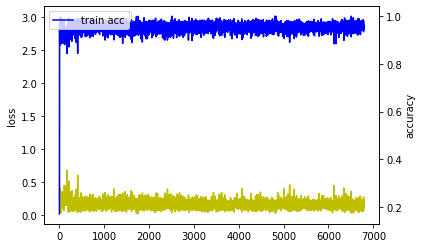

mean acc : 0.9525433062659725


In [68]:
#8. plot the Trainning Result
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss=[]
acc = []
mean_acc = 0
for his in hist2:
    loss.append(his.history['loss'])
   # print(his.history['loss'][0])
    acc.append(his.history['accuracy'])
    mean_acc += his.history['accuracy'][0]

mean_acc = mean_acc/ len(hist2)
    
loss_ax.plot(loss, 'y', label='train loss')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(acc, 'b', label='train acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()
print( 'mean acc : ' + str(mean_acc))

In [97]:
#9. plot the Trainning Result
model.save_weights('Weight_POS_LSTM.h5')

In [103]:
#10. load model from saved weight
model2 = Sequential()
n_units = 50
embedding_size = 100

model2.add(InputLayer(input_shape = (None,300)))
model2.add(Bidirectional(LSTM(n_units)))

model2.add(Dense(target_counter))
model2.add(Activation('softmax'))
model2.load_weights('Weight_POS_LSTM.h5')
model2.compile(loss='categorical_crossentropy', optimizer=Adam(0.01),\
              metrics=['accuracy'])
model2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_17 (Dense)             (None, 46)                4646      
_________________________________________________________________
activation_17 (Activation)   (None, 46)                0         
Total params: 145,046
Trainable params: 145,046
Non-trainable params: 0
_________________________________________________________________


In [105]:
# 11.Test data read and predicit the Result
f = open("test.txt", 'r')
test_text = f.read()
#print(test_text)
f.close()
test_text = test_text.replace('\n' ,' ')
test_text = test_text.replace('\"' ,' ')
test_text = test_text.replace(',' ,' ')
test_text = test_text.replace('.' ,' ')
#test_text = 'They have access to the files'
tlist=test_text.split(' ')
tlist

test_v = []
#word_counter2 = word_counter
for s in tlist:
    #print(dic[t])
    
    test_v.append(get_vector(s))

tv,seqq = generate_sequences2(test_v,1)
tv = np.array(tv)
result_softmax = model2.predict(tv)


Number of sequences: 1178 



In [106]:
# 12. Print predicted data and Write result data to result2_POS_tagged_Gensim.txt
def findmaxidx(lst):
    maxl = 0
    idxre = 0
    for idx,l in enumerate(lst):
        if l > maxl:
            maxl = l
            idxre = idx
    return idxre

dicl = list(dic.keys())
f2 = open('result2_POS_tagged_Gensim.txt', 'w', encoding='utf-8', newline='')
for idx,r in enumerate(result_softmax):
    pos = findmaxidx(r)
    resultpos = dicl[pos]
    ss = str(tlist[idx]) + ' '  + str(resultpos)
    print (ss)
    f2.write(ss + '\n')
f2.close()

Federal NNP
Reserve NNP
officials NNS
predicted VBN
they PRP
would MD
keep VB
interest NN
rates NNS
close RB
to TO
zero CD
until IN
at IN
least JJS
the DT
end NN
of IN
2022 JJ
 NN
as IN
the DT
US NNP
central JJ
bank NN
indicated VBN
it PRP
would MD
take VB
years NNS
to TO
bring VB
joblessness NN
back RB
down NN
to TO
the DT
levels NNS
before IN
the DT
coronavirus NN
pandemic JJ
 JJ
 NN
The DT
dovish JJ
tone NN
from IN
the DT
Fed NNP
 NN
which WDT
is VBZ
expecting VBG
the DT
US NNP
economy NN
to TO
contract NN
by IN
6 CD
5 CD
per IN
cent NN
this DT
year NN
 NN
with IN
unemployment NN
falling VBG
to TO
9 CD
3 CD
per IN
cent NN
 NN
reinforced VBD
expectations NNS
that IN
the DT
central JJ
bank NN
was VBD
settling VBG
in IN
for IN
an DT
extended JJ
fight NN
against IN
the DT
economic JJ
shock NN
triggered VBN
by IN
the DT
virus NN
 NN
 NN
In IN
a DT
policy NN
statement NN
that DT
was VBD
mostly RB
unchanged JJ
compared VBN
with IN
April NNP
 NNP
the DT
Federal NNP
Open NNP
Market NNP
Commi

In [148]:
# 13.Compare with NLTK data
tokens = nltk.word_tokenize(test_text)
tagged = nltk.pos_tag(tokens)
l1 = ' '.join([word for word, pos in tagged])
l2 = ' '.join([pos for word, pos in tagged])
tagged

[('Federal', 'NNP'),
 ('Reserve', 'NNP'),
 ('officials', 'NNS'),
 ('predicted', 'VBD'),
 ('they', 'PRP'),
 ('would', 'MD'),
 ('keep', 'VB'),
 ('interest', 'NN'),
 ('rates', 'NNS'),
 ('close', 'RB'),
 ('to', 'TO'),
 ('zero', 'CD'),
 ('until', 'IN'),
 ('at', 'IN'),
 ('least', 'JJS'),
 ('the', 'DT'),
 ('end', 'NN'),
 ('of', 'IN'),
 ('2022', 'CD'),
 ('as', 'IN'),
 ('the', 'DT'),
 ('US', 'NNP'),
 ('central', 'JJ'),
 ('bank', 'NN'),
 ('indicated', 'VBD'),
 ('it', 'PRP'),
 ('would', 'MD'),
 ('take', 'VB'),
 ('years', 'NNS'),
 ('to', 'TO'),
 ('bring', 'VB'),
 ('joblessness', 'NN'),
 ('back', 'RB'),
 ('down', 'RB'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('levels', 'NNS'),
 ('before', 'IN'),
 ('the', 'DT'),
 ('coronavirus', 'NN'),
 ('pandemic', 'NN'),
 ('.', '.'),
 ('The', 'DT'),
 ('dovish', 'JJ'),
 ('tone', 'NN'),
 ('from', 'IN'),
 ('the', 'DT'),
 ('Fed', 'NNP'),
 ('which', 'WDT'),
 ('is', 'VBZ'),
 ('expecting', 'VBG'),
 ('the', 'DT'),
 ('US', 'NNP'),
 ('economy', 'NN'),
 ('to', 'TO'),
 ('contract', 